In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle, joblib
import random, time, os, re
from scipy import interp
import xml.etree.ElementTree as et
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,roc_curve,auc,roc_auc_score
import torch
import torchtext
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from torchtext.vocab import GloVe
from torchtext.legacy.data import Field, BucketIterator, Dataset, Example, TabularDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import spacy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("punkt")
nlp = spacy.load("en")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f"There are {torch.cuda.device_count()} GPUs available!!")
  print("GPU is:", torch.cuda.get_device_name(0))
else:
  print("No GPU available!!")
  device = torch.device("cpu")

There are 1 GPUs available!!
GPU is: Tesla P100-PCIE-16GB


In [5]:
# embedding = GloVe(name="840B", dim=300)
# pickle.dump(embedding,open('/content/drive/MyDrive/DL/glove_embedding.pkl','wb'))

In [6]:
embedding = pickle.load(open("/content/drive/MyDrive/DL/glove_embedding.pkl",'rb'))

In [7]:
def convert_xml_to_dataframe(path=""):
  xtree = et.parse(path)
  xroot = xtree.getroot()
  rows = []
  for node in xroot:
    id = node.attrib.get('id')
    txt = node.find("text").text
    asptTerm = node.find("aspectTerms")
    if asptTerm is None:
      continue
    for aspect in node.iter('aspectTerms'):
      for aspt in aspect.iter('aspectTerm'):
        term = aspt.attrib.get('term')
        polarity = aspt.attrib.get('polarity')
        if polarity == 'conflict':
          continue
        rows.append({"context":txt,"target":term,"polarity":polarity})
  df = pd.DataFrame(rows,columns=['context','target','polarity'])
  return df

In [8]:
def encode_labels(df,col_name):
  label = df[col_name]
  l = LabelEncoder()
  label=l.fit_transform(label)
  df[col_name] = label
  return df

In [9]:
laptop_train = convert_xml_to_dataframe('/content/drive/MyDrive/DL/ABSA complete Dataset/ABSA Train/Laptops_Train.xml')
laptop_test = convert_xml_to_dataframe('/content/drive/MyDrive/DL/ABSA complete Dataset/ABSA Test/Laptops_Test_Gold.xml')
restaurant_train = convert_xml_to_dataframe('/content/drive/MyDrive/DL/ABSA complete Dataset/ABSA Train/Restaurants_Train.xml')
restaurant_test = convert_xml_to_dataframe('/content/drive/MyDrive/DL/ABSA complete Dataset/ABSA Test/Restaurants_Test_Gold.xml')
laptop_train = encode_labels(laptop_train,'polarity')
restaurant_train = encode_labels(restaurant_train,'polarity')
laptop_test = encode_labels(laptop_test,'polarity')
restaurant_test = encode_labels(restaurant_test,'polarity')

In [10]:
def tokenize_and_build_vocabulary(context1,target1, context2, target2):
  max_len_context, max_len_target = 0, 0
  tokenized_context1, tokenized_target1 = list(), list()
  tokenized_context2, tokenized_target2 = list(), list()
  target_lens1, context_lens1, target_lens2, context_lens2 = list(), list(), list(), list()
  word2idx = dict()
  word2idx["<pad>"] = 0
  word2idx["<unk>"] = 1
  idx = 2
  for i in range(len(context1)):
    sentence = context1[i].strip()
    # sentence = re.sub('[^a-zA-Z0-9]',' ',sentence)
    sentence = sentence.lower()
    tokenized_sentence1 = word_tokenize(sentence)
    tokenized_context1.append(tokenized_sentence1)
    context_lens1.append(len(tokenized_sentence1)-1)
    for word in tokenized_sentence1:
      if word not in word2idx:
        word2idx[word] = idx
        idx += 1
    max_len_context = max(max_len_context,len(tokenized_sentence1))
    sent = target1[i].strip()
    # sent = re.sub('[^a-zA-Z0-9]',' ',sent)
    sent = sent.lower()
    tokenized_sent1 = word_tokenize(sent)
    tokenized_target1.append(tokenized_sent1)
    target_lens1.append(len(tokenized_sent1))
    for word in tokenized_sent1:
      if word not in word2idx:
        word2idx[word] = idx
        idx += 1
    max_len_target = max(max_len_target,len(tokenized_sent1))
  
  for i in range(len(context2)):
    sentence = context2[i].strip()
    # sentence = re.sub('[^a-zA-Z0-9]',' ',sentence)
    sentence = sentence.lower()
    tokenized_sentence2 = word_tokenize(sentence)
    tokenized_context2.append(tokenized_sentence2)
    context_lens2.append(len(tokenized_sentence2)-1)
    for word in tokenized_sentence2:
      if word not in word2idx:
        word2idx[word] = idx
        idx += 1
    max_len_context = max(max_len_context,len(tokenized_sentence2))
    sent = target2[i].strip()
    # sent = re.sub('[^a-zA-Z0-9]',' ',sent)
    sent = sent.lower()
    tokenized_sent2 = word_tokenize(sent)
    tokenized_target2.append(tokenized_sent2)
    target_lens2.append(len(tokenized_sent2))
    for word in tokenized_sent2:
      if word not in word2idx:
        word2idx[word] = idx
        idx += 1
    max_len_target = max(max_len_target,len(tokenized_sent2))

  return tokenized_context1, tokenized_target1, np.array(context_lens1), np.array(target_lens1), tokenized_context2, tokenized_target2, np.array(context_lens2), np.array(target_lens2), word2idx, max_len_context, max_len_target

In [11]:
def encode_tokenized_text(tokenized_text,word2idx,max_len):
  encoded_text = list()
  for tokenized_sentence in tokenized_text:
    tokenized_sentence += ["<pad>"] * (max_len-len(tokenized_sentence))
    encode_text = [word2idx[word] for word in tokenized_sentence]
    encoded_text.append(encode_text)
  return np.array(encoded_text)

In [12]:
def load_pretrained_vectors(word2idx,embedding,dim):
  cnt = 0
  embedding_matrix = np.random.uniform(-0.1,0.1,(len(word2idx),dim))
  embedding_matrix[word2idx["<pad>"]] = torch.from_numpy(np.zeros((dim,)))
  for word in word2idx.keys():
    if word in embedding.itos:
      cnt += 1
      embedding_matrix[word2idx[word]] = embedding[word]
  print("There are {}/{} pretrained vectors found".format(cnt,len(word2idx)))
  return embedding_matrix

In [13]:
class ABSADataset(Dataset):
  def __init__(self,context,target,polarity,context_lens,target_lens,max_len_context,max_len_target):
    self.target = torch.tensor(target).long()
    self.context = torch.tensor(context).long()
    self.polarity = torch.tensor(polarity).long()
    self.context_lens = torch.tensor(context_lens).long()
    self.target_lens = torch.tensor(target_lens).long()
    self.len = self.polarity.shape[0]
    self.context_mask = torch.zeros(max_len_context, max_len_context)
    self.target_mask = torch.zeros(max_len_target, max_len_target)
    for i in range(max_len_context):
      self.context_mask[i,0:(i+1)] = 1
    for i in range(max_len_target):
      self.target_mask[i,0:(i+1)] = 1

  def __getitem__(self,index):
    return self.context[index], self.target[index], self.polarity[index], self.context_mask[self.context_lens[index]-1],self.target_mask[self.target_lens[index]-1] 

  def __len__(self):
    return self.len

In [14]:
class Attention(nn.Module):
  def __init__(self,query_size,key_size):
    super(Attention,self).__init__()
    self.weights = nn.Parameter(torch.rand(key_size,query_size)*0.2-0.1)
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self,query,key,mask):
    batch_size = key.size(0)
    time_step = key.size(1)
    weight = self.weights.repeat(batch_size,1,1)
    query = query.unsqueeze(-1)
    mids = weight.matmul(query)
    mids = mids.repeat(time_step,1,1,1).transpose(0,1)
    key = key.unsqueeze(-2)
    scores = torch.tanh(key.matmul(mids).squeeze()+self.bias)
    scores = scores.squeeze()
    scores = scores - scores.max(dim=1, keepdim=True)[0]
    scores = torch.exp(scores)*mask
    attn_weights = scores/scores.sum(dim=1,keepdim=True)
    return attn_weights

In [15]:
class InteractiveAttentionNetwork(nn.Module):

  target_atn = None
  context_atn = None

  def __init__(self,pretrained_embedding=None,freeze_embedding=False,vocab_size=None,
               embed_dim=300,hidden_dim = 300,num_classes = 3,dropout = 0.5,
               max_len_context=0,max_len_target=0,l2_reg=0,attention_flag=True):
    
    super(InteractiveAttentionNetwork,self).__init__()

    self.hidden_dim=hidden_dim
    self.num_classes = num_classes
    self.l2_reg = l2_reg
    self.max_len_context = max_len_context
    self.max_len_target = max_len_target
    self.attention_flag = attention_flag
    # self.target_atn = None
    # self.context_atn = None

    
    if pretrained_embedding is not None:
      self.vocab_size, self.embed_dim = pretrained_embedding.shape
      self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,freeze = freeze_embedding)
    else:
      self.embed_dim = embed_dim
      self.vocab_size = vocab_size
      self.embedding = nn.Embedding(num_embeddings=self.vocab_size,embedding_dim=self.embed_dim,padding_idx=0,max_norm=5.0)
    
    self.target_lstm = nn.LSTM(input_size = self.embed_dim, hidden_size = self.hidden_dim, batch_first = True)
    self.context_lstm = nn.LSTM(input_size = self.embed_dim, hidden_size = self.hidden_dim, batch_first = True)
    if self.attention_flag == True:
      self.target_attn = Attention(self.hidden_dim, self.hidden_dim)
      self.context_attn = Attention(self.hidden_dim, self.hidden_dim)
    self.dropout = nn.Dropout(p=dropout)
    self.fc = nn.Linear(self.hidden_dim*2, self.num_classes)

  def forward(self, context, target, context_mask, target_mask):
    target = self.embedding(target).float()
    target = self.dropout(target)
    target_output, _ = self.target_lstm(target)
    target_output = target_output * target_mask.unsqueeze(-1)
    target_avg = target_output.sum(dim=1, keepdim=False) / target_mask.sum(dim=1, keepdim=True)

    context = self.embedding(context).float()
    context = self.dropout(context)
    context_output, _ = self.context_lstm(context)
    context_output = context_output * context_mask.unsqueeze(-1)
    context_avg = context_output.sum(dim=1, keepdim=False) / context_mask.sum(dim=1, keepdim=True)

    if self.attention_flag == True:
      self.target_atn = self.target_attn(context_avg, target_output, target_mask).unsqueeze(1)
      target_features = self.target_atn.matmul(target_output).squeeze()
      self.context_atn = self.context_attn(target_avg, context_output, context_mask).unsqueeze(1)
      context_features = self.context_atn.matmul(context_output).squeeze()
      features = torch.cat([target_features,context_features], dim=1)
    else:
      features = torch.cat([target_avg, context_avg], dim=1)
    features = self.dropout(features)
    logits = self.fc(features)
    logits = torch.tanh(logits)
    return logits

In [16]:
def initialize_model(pretrained_embedding=None,freeze_embedding=False,vocab_size=None,
                      embed_dim=300,hidden_dim = 300,num_classes = 3,dropout = 0.5,
                      max_len_context=0,max_len_target=0,l2_reg=0,attention_flag=True,learning_rate=0.01):
  ian_model = InteractiveAttentionNetwork(pretrained_embedding=pretrained_embedding, freeze_embedding=freeze_embedding, vocab_size=None, embed_dim=embed_dim,
                  hidden_dim=hidden_dim,num_classes=num_classes, dropout=dropout, max_len_context=max_len_context,
                  max_len_target=max_len_target, l2_reg=l2_reg, attention_flag=attention_flag)
  ian_model.to(device)
  optimizer = optim.Adam(ian_model.parameters(), lr = learning_rate, weight_decay=l2_reg)
  return ian_model, optimizer
  

In [17]:
def evaluate(model,test_dataloader):
  model.eval()
  test_accuracy, test_loss = list(), list()
  for batch in test_dataloader:
    context, target, labels, context_mask, target_mask = tuple(t.to(device) for t in batch)
    logits = model(context,target,context_mask,target_mask)
    loss = loss_fn(logits,labels)
    preds = torch.argmax(logits,dim=1).flatten()
    test_loss.append(loss.item())
    accuracy = (preds == labels).cpu().numpy().mean() * 100
    test_accuracy.append(accuracy)

  test_loss = np.mean(test_loss)
  test_accuracy = np.mean(test_accuracy)
  return test_loss, test_accuracy

In [18]:
def train(model, optimizer, train_dataloader, test_dataloader=None, epochs=10, path=""):
  best_accuracy = 0
  print(f"{'Epoch':^6} | {'Train Loss':^12} | {'Train Accuracy':^10} | {'Test Loss':^10} | {'Test Accuracy':^10} | {'Elapsed':^9}")
  print("-"*80)
  training_loss, testing_loss = list(), list()
  # loss1, accuracy1 = list(), list()
  for i in range(epochs):
    t0 = time.time()
    loss1, accuracy1 = list(), list()
    total_loss, total_accuracy = 0, 0
    model.train()
    for step,batch in enumerate(train_dataloader):
      context, target, labels, context_mask, target_mask = tuple(t.to(device) for t in batch)
      optimizer.zero_grad()
      logits = model(context,target,context_mask,target_mask)
      loss = loss_fn(logits,labels)
      total_loss += loss.item()
      loss1.append(loss.item())
      preds = torch.argmax(logits,dim=1).flatten()
      accuracy = (preds == labels).cpu().numpy().mean() * 100
      accuracy1.append(accuracy)
      total_accuracy += accuracy
      loss.backward()
      optimizer.step()
    
    average_train_loss = np.mean(loss1)
    average_train_accuracy = np.mean(accuracy1)
    training_loss.append(average_train_loss)

    if test_dataloader is not None:
      test_loss, test_accuracy = evaluate(model, test_dataloader)
      testing_loss.append(test_loss)
      if test_accuracy>best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model,path)
      time_elapsed = time.time()-t0
      print(f"{i+1:^6} | {average_train_loss:^12.6f} | {average_train_accuracy:^14.6f} | {test_loss:^10.6f} | {test_accuracy:^10.6f} | {time_elapsed:^9.3f}")

  print(f"Training Complete!! \nBest accuracy reported on test set: {best_accuracy:.2f}%\nThis model was saved!!!")
  print("\n")
  return training_loss, testing_loss

In [19]:
def plot_loss_curves(path,train_loss,test_loss,num_of_epochs):
  epch = list(range(num_of_epochs))
  plt.figure(figsize=(15,10))
  plt.plot(epch, train_loss)
  plt.plot(epch, test_loss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Training Loss', 'Testing Loss'])
  plt.title('Loss vs Epochs')
  # plt.savefig(path)
  plt.show()

In [20]:
def illustrate_attention_weights(model,dataloader,word2idx,path):
  model.eval()
  count = 0
  target_atn, tar, con, context_atn, pred, true_label = None, None, None, None, None, None
  context_words, target_words = list(), list()
  test_accuracy, test_loss = list(), list()
  word_list = list(word2idx.keys())
  # print(word_list[27])
  for batch in dataloader:
    context, target, labels, context_mask, target_mask = tuple(t.to(device) for t in batch)
    logits = model(context,target,context_mask,target_mask)
    preds = torch.argmax(logits,dim=1).flatten()
    true_label = labels[:10].detach().cpu().numpy()
    pred = preds[:10].detach().cpu().numpy()
    target_atn = model.target_atn[:10].detach().cpu().numpy()
    context_atn = model.context_atn[:10].detach().cpu().numpy()
    tar = target[:10].cpu().numpy()
    con = context[:10].cpu().numpy()
    count+=1
    if count==1:
      break

  for i in range(len(tar)):
    words = list()
    for idx in range(len(tar[i])):
      index=tar[i][idx]
      word = word_list[tar[i][idx]]
      if word != "<pad>":
        words.append(word)
    target_words.append(words)

  for i in range(len(con)):
    words = list()
    for idx in range(len(con[i])):
      index=con[i][idx]
      word = word_list[con[i][idx]]
      if word != "<pad>":
        words.append(word)
    context_words.append(words)
  
  final_context_atn, final_target_atn = list(), list()

  for i in range(len(context_atn)):
    length_con = len(context_words[i])
    atn = context_atn[i][0][:length_con]
    final_context_atn.append(atn)

  for i in range(len(target_atn)):
    length_con = len(target_words[i])
    atn = target_atn[i][0][:length_con]
    final_target_atn.append(atn)

  for i in range(10):
    path1 = path+"/target"+str(i)+".jpg"
    path2 = path+"/context"+str(i)+".jpg"
    X1 = final_target_atn[i]
    w1 = target_words[i]
    plt.figure(figsize=(7,1))
    sn.heatmap([X1],cmap='YlGnBu',linewidths=0.5,linecolor="black",xticklabels=w1,yticklabels=False)
    # plt.savefig(path1)
    plt.show()
    X2 = final_context_atn[i][:-1]
    w2 = context_words[i][:-1]
    plt.figure(figsize=(20,1))
    sn.heatmap([X2],cmap='YlGnBu',linewidths=0.5,linecolor="black",xticklabels=w2,yticklabels=False)
    # plt.savefig(path2)
    plt.show()

  # print('\n')
  # print(f"{'Context':^50} | {'Target':^10} | {'Output':^8} | {'True Label':^8}")
  # print("-"*120)
  # polarity = {0:"negative", 1:"neutral", 2:"positive"}
  # for i in range(len(pred)):
  #   complete_context = ' '.join(context_words[i][:-1])
  #   complete_target = ' '.join(target_words[i])
  #   output = polarity[pred[i]]
  #   true_l = polarity[true_label[i]]
  #   print(f"{complete_context:^50} | {complete_target:^10} | {output:^8} | {true_l:^8}\n")

In [21]:
def display_prediction(model,dataloader,word2idx):
  model.eval()
  count = 0
  target_atn, tar, con, context_atn, pred, true_label = None, None, None, None, None, None
  context_words, target_words = list(), list()
  test_accuracy, test_loss = list(), list()
  word_list = list(word2idx.keys())
  # print(word_list[27])
  for batch in dataloader:
    context, target, labels, context_mask, target_mask = tuple(t.to(device) for t in batch)
    logits = model(context,target,context_mask,target_mask)
    preds = torch.argmax(logits,dim=1).flatten()
    true_label = labels[:10].detach().cpu().numpy()
    pred = preds[:10].detach().cpu().numpy()
    tar = target[:10].cpu().numpy()
    con = context[:10].cpu().numpy()
    count+=1
    if count==1:
      break
  for i in range(len(tar)):
    words = list()
    for idx in range(len(tar[i])):
      index=tar[i][idx]
      word = word_list[tar[i][idx]]
      if word != "<pad>":
        words.append(word)
    target_words.append(words)

  for i in range(len(con)):
    words = list()
    for idx in range(len(con[i])):
      index=con[i][idx]
      word = word_list[con[i][idx]]
      if word != "<pad>":
        words.append(word)
    context_words.append(words)
  
  print('\n')
  print(f"{'Context':^50} | {'Target':^10} | {'Output':^8} | {'True Label':^8}")
  print("-"*120)
  polarity = {0:"negative", 1:"neutral", 2:"positive"}
  for i in range(len(pred)):
    complete_context = ' '.join(context_words[i][:-1])
    complete_target = ' '.join(target_words[i])
    output = polarity[pred[i]]
    true_l = polarity[true_label[i]]
    print(f"{complete_context:^50} | {complete_target:^10} | {output:^8} | {true_l:^8}\n")

## Restaurant Dataset

In [20]:
r_train_context, r_train_target, r_train_polarity = np.array(restaurant_train['context']), np.array(restaurant_train['target']), np.array(restaurant_train['polarity'])
r_test_context, r_test_target, r_test_polarity = np.array(restaurant_test['context']), np.array(restaurant_test['target']), np.array(restaurant_test['polarity'])

In [21]:
rtrain_tokenized_context, rtrain_tokenized_target,rtrain_context_lens, rtrain_target_lens, rtest_tokenized_context, rtest_tokenized_target,rtest_context_lens, rtest_target_lens, word2idx, max_len_context, max_len_target = tokenize_and_build_vocabulary(r_train_context, r_train_target, r_test_context, r_test_target)
rtrain_encoded_context = encode_tokenized_text(rtrain_tokenized_context, word2idx, max_len_context)
rtest_encoded_context = encode_tokenized_text(rtest_tokenized_context, word2idx, max_len_context)
rtrain_encoded_target = encode_tokenized_text(rtrain_tokenized_target, word2idx, max_len_target)
rtest_encoded_target = encode_tokenized_text(rtest_tokenized_target, word2idx, max_len_target)
r_embedding_matrix = load_pretrained_vectors(word2idx,embedding,300)
r_embedding_matrix = torch.tensor(r_embedding_matrix)

There are 4343/4574 pretrained vectors found


In [22]:
r_train_dataset = ABSADataset(rtrain_encoded_context, rtrain_encoded_target, r_train_polarity,rtrain_context_lens, rtrain_target_lens,max_len_context, max_len_target)
r_train_loader = DataLoader(dataset=r_train_dataset, batch_size=128, shuffle=True, num_workers=2)

In [23]:
r_test_dataset = ABSADataset(rtest_encoded_context, rtest_encoded_target, r_test_polarity,rtest_context_lens, rtest_target_lens,max_len_context, max_len_target)
r_test_loader = DataLoader(dataset=r_test_dataset, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)


Epoch  |  Train Loss  | Train Accuracy | Test Loss  | Test Accuracy |  Elapsed 
--------------------------------------------------------------------------------
  1    |   0.907365   |   60.470546    |  0.755254  | 69.444444  |   2.136  
  2    |   0.769640   |   68.597342    |  0.680558  | 74.565972  |   2.025  
  3    |   0.696826   |   72.961566    |  0.657868  | 75.839120  |   2.021  
  4    |   0.645818   |   75.915948    |  0.645391  | 75.896991  |   2.021  
  5    |   0.607813   |   78.439296    |  0.625738  | 77.633102  |   2.008  
  6    |   0.577815   |   80.854885    |  0.626775  | 78.385417  |   2.012  
  7    |   0.558894   |   81.178161    |  0.634829  | 76.996528  |   1.945  
  8    |   0.541057   |   82.444325    |  0.638796  | 77.112269  |   1.948  
  9    |   0.511163   |   84.401940    |  0.637906  | 77.372685  |   1.963  
  10   |   0.498122   |   85.569325    |  0.643807  | 76.736111  |   1.963  
  11   |   0.481724   |   86.619971    |  0.645551  | 77.401620  |   

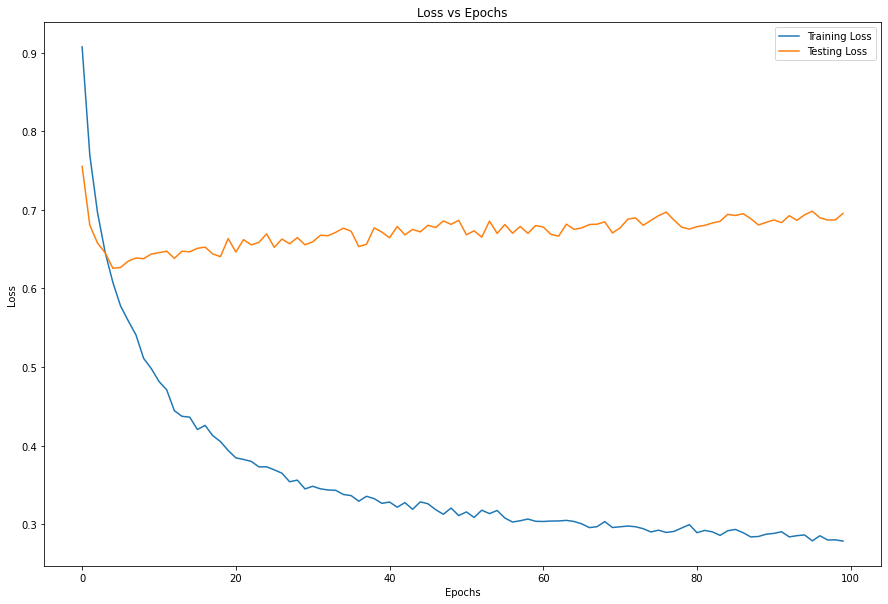



Train Loss: 0.531983
Training Accuracy: 83.899%



Test Loss: 0.629331
Testing Accuracy: 78.125%


Five Samples from Train Dataset


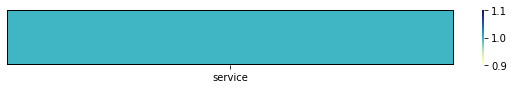

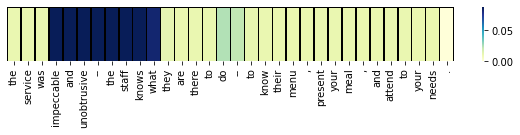

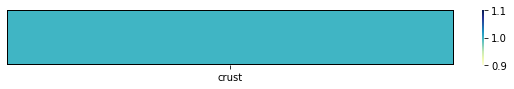

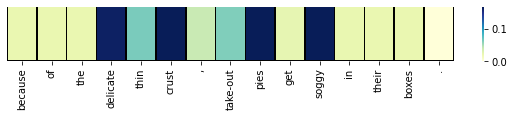

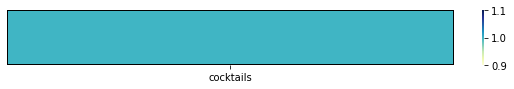

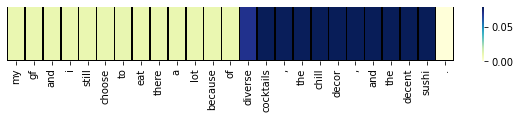

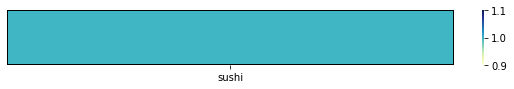

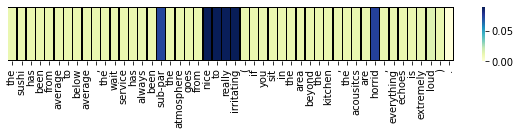

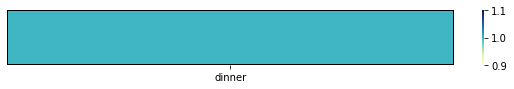

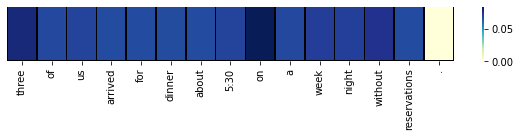

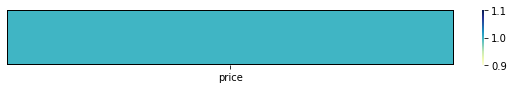

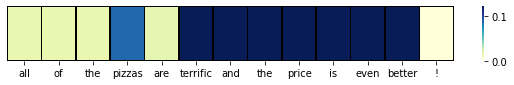

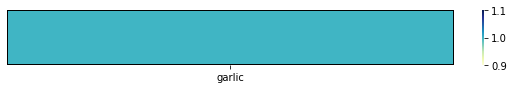

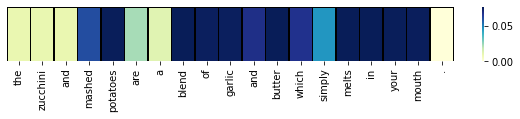

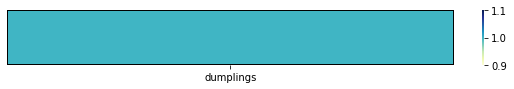

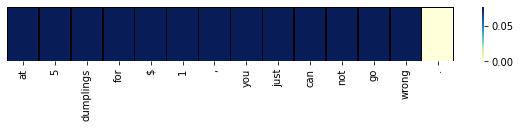

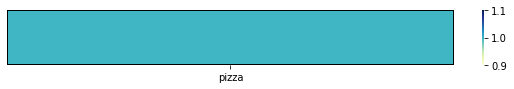

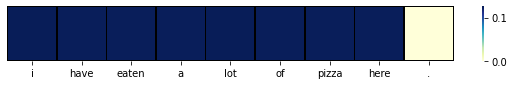

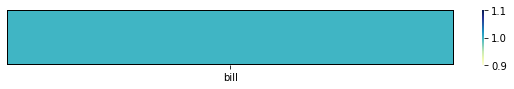

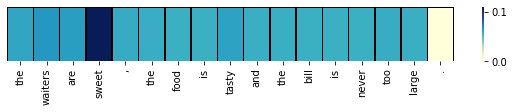

Five Sample from Test Dataset


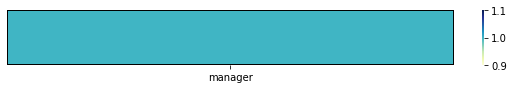

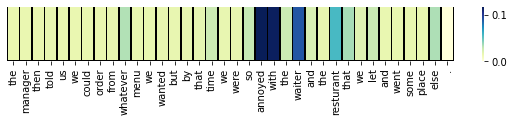

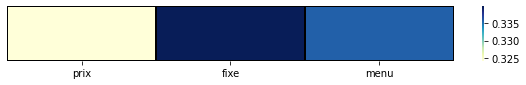

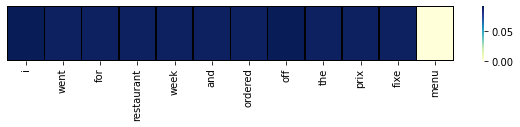

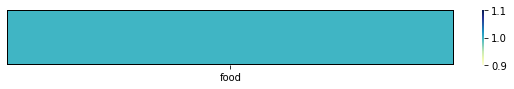

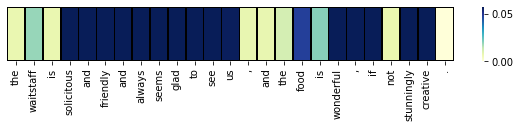

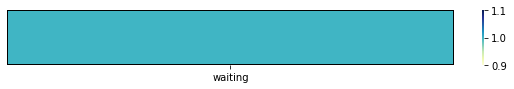

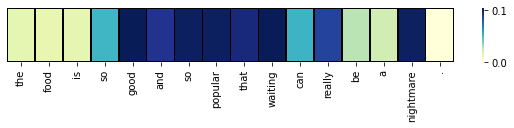

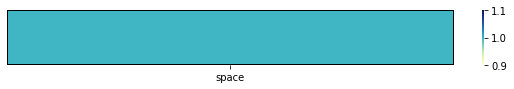

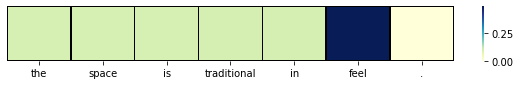

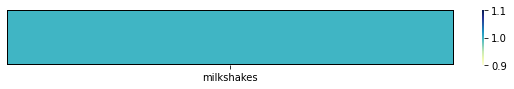

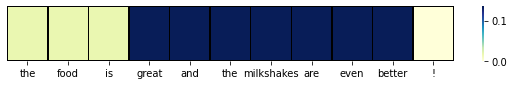

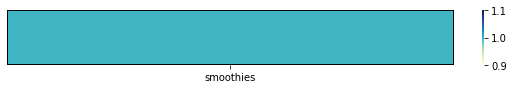

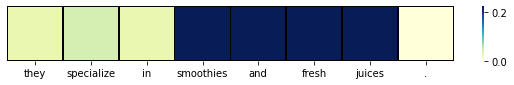

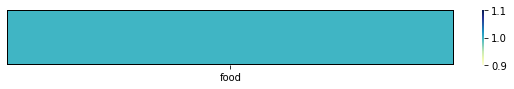

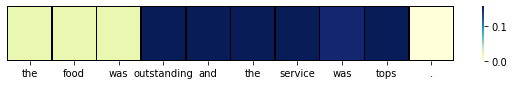

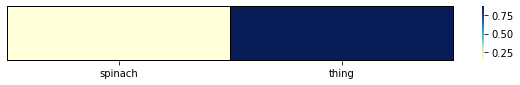

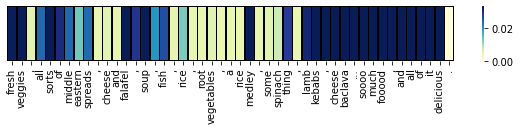

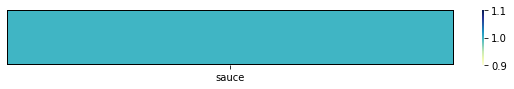

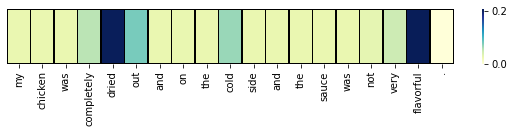

In [ ]:
set_seed(seed_value=42)
ian_model_with_attn, optimizer = initialize_model(pretrained_embedding = r_embedding_matrix,freeze_embedding = False,hidden_dim=300,
                             num_classes=3,dropout=0.5,max_len_context=max_len_context, max_len_target=max_len_target, l2_reg=0,
                             attention_flag=True,learning_rate=0.001)
epoch = 100
training_loss, testing_loss = train(model=ian_model_with_attn, optimizer=optimizer,train_dataloader=r_train_loader,test_dataloader=r_test_loader, epochs=epoch,path='/content/drive/MyDrive/DL/rian_model_with_attn.pth')
ian_model_with_attn = torch.load('/content/drive/MyDrive/DL/rian_model_with_attn.pth')
test_loss, test_accuracy = evaluate(model=ian_model_with_attn,test_dataloader=r_test_loader)
train_loss, train_accuracy = evaluate(model=ian_model_with_attn,test_dataloader=r_train_loader)
plot_loss_curves(path = "/content/drive/MyDrive/DL/rloss-epoch1.jpg", train_loss=training_loss, test_loss=testing_loss, num_of_epochs=epoch)
print('\n')

print(f"Train Loss: {train_loss:.6f}")
print(f"Training Accuracy: {train_accuracy:.3f}%")
print("\n\n")
print(f"Test Loss: {test_loss:.6f}")
print(f"Testing Accuracy: {test_accuracy:.3f}%")
print('\n')

print("Five Samples from Train Dataset")
illustrate_attention_weights(model=ian_model_with_attn, dataloader=r_train_loader, word2idx=word2idx,path="/content/drive/MyDrive/DL/Train/Restaurant")
print("Five Sample from Test Dataset")
illustrate_attention_weights(model=ian_model_with_attn, dataloader=r_test_loader, word2idx=word2idx,path="/content/drive/MyDrive/DL/Test/Restaurant")

Epoch  |  Train Loss  | Train Accuracy | Test Loss  | Test Accuracy |  Elapsed 
--------------------------------------------------------------------------------
  1    |   0.936452   |   58.225575    |  0.779416  | 66.203704  |   1.886  
  2    |   0.778643   |   67.852011    |  0.711967  | 74.450231  |   1.798  
  3    |   0.704369   |   72.422773    |  0.671190  | 75.347222  |   1.798  
  4    |   0.647035   |   75.996767    |  0.673375  | 74.797454  |   1.745  
  5    |   0.614563   |   78.556034    |  0.657275  | 75.694444  |   1.790  
  6    |   0.587316   |   80.630388    |  0.656090  | 76.302083  |   1.765  
  7    |   0.556791   |   82.246767    |  0.653639  | 75.954861  |   1.732  
  8    |   0.537355   |   82.974138    |  0.658707  | 75.925926  |   1.729  
  9    |   0.506603   |   85.228089    |  0.668472  | 74.942130  |   1.731  
  10   |   0.504484   |   85.299928    |  0.671126  | 76.041667  |   1.724  
  11   |   0.489827   |   86.278736    |  0.672713  | 74.855324  |   

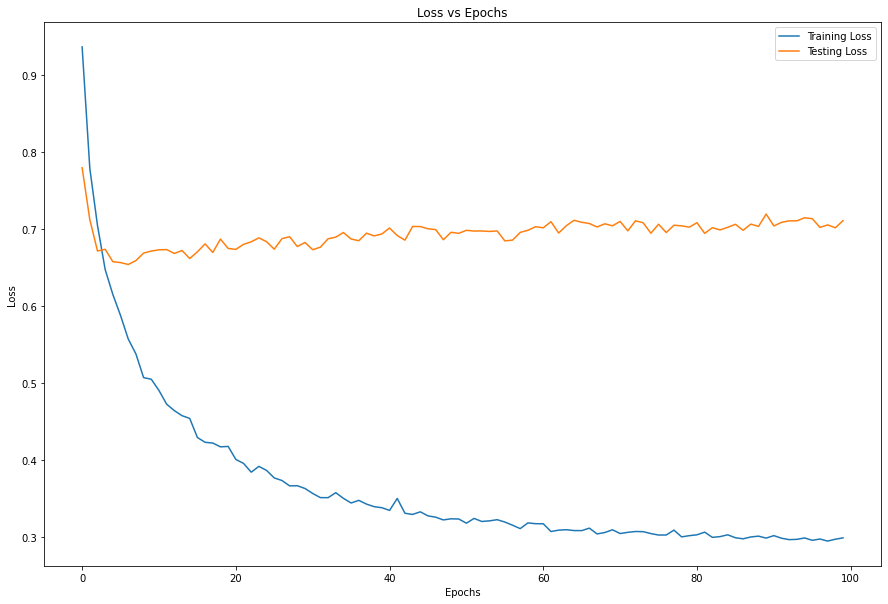

Train Loss: 0.528658
Training Accuracy: 83.998%



Test Loss: 0.656263
Testing Accuracy: 76.331%




In [ ]:
set_seed(seed_value=42)
ian_model_without_attn, optimizer = initialize_model(pretrained_embedding = r_embedding_matrix,freeze_embedding = False,hidden_dim=300,
                             num_classes=3,dropout=0.5,max_len_context=max_len_context, max_len_target=max_len_target, l2_reg=0,
                             attention_flag=False,learning_rate=0.001)
epoch = 100
training_loss, testing_loss = train(model=ian_model_without_attn, optimizer=optimizer,train_dataloader=r_train_loader,test_dataloader=r_test_loader, epochs=epoch,path='/content/drive/MyDrive/DL/rian_model_without_attn.pth')
ian_model_without_attn = torch.load('/content/drive/MyDrive/DL/rian_model_without_attn.pth')
test_loss, test_accuracy = evaluate(model=ian_model_without_attn,test_dataloader=r_test_loader)
train_loss, train_accuracy = evaluate(model=ian_model_without_attn,test_dataloader=r_train_loader)
plot_loss_curves(path = "/content/drive/MyDrive/DL/rloss-epoch2.jpg", train_loss=training_loss, test_loss=testing_loss, num_of_epochs=epoch)

print(f"Train Loss: {train_loss:.6f}")
print(f"Training Accuracy: {train_accuracy:.3f}%")
print("\n\n")
print(f"Test Loss: {test_loss:.6f}")
print(f"Testing Accuracy: {test_accuracy:.3f}%")
print('\n')


Epoch  |  Train Loss  | Train Accuracy | Test Loss  | Test Accuracy |  Elapsed 
--------------------------------------------------------------------------------
  1    |   0.908210   |   60.326868    |  0.756397  | 69.531250  |   2.479  
  2    |   0.800738   |   65.642960    |  0.715099  | 72.829861  |   2.370  
  3    |   0.726954   |   71.201509    |  0.669293  | 75.491898  |   2.357  
  4    |   0.668414   |   74.856322    |  0.661333  | 75.665509  |   2.370  
  5    |   0.619869   |   78.241739    |  0.642667  | 76.707176  |   2.351  
  6    |   0.589906   |   80.235273    |  0.653267  | 76.388889  |   2.315  
  7    |   0.562564   |   80.854885    |  0.660527  | 76.504630  |   2.286  
  8    |   0.554929   |   81.761853    |  0.638486  | 76.822917  |   2.412  
  9    |   0.529885   |   83.566810    |  0.646403  | 76.678241  |   2.284  
  10   |   0.495316   |   86.341595    |  0.655597  | 76.793981  |   2.283  
  11   |   0.488734   |   86.000359    |  0.652990  | 76.388889  |   

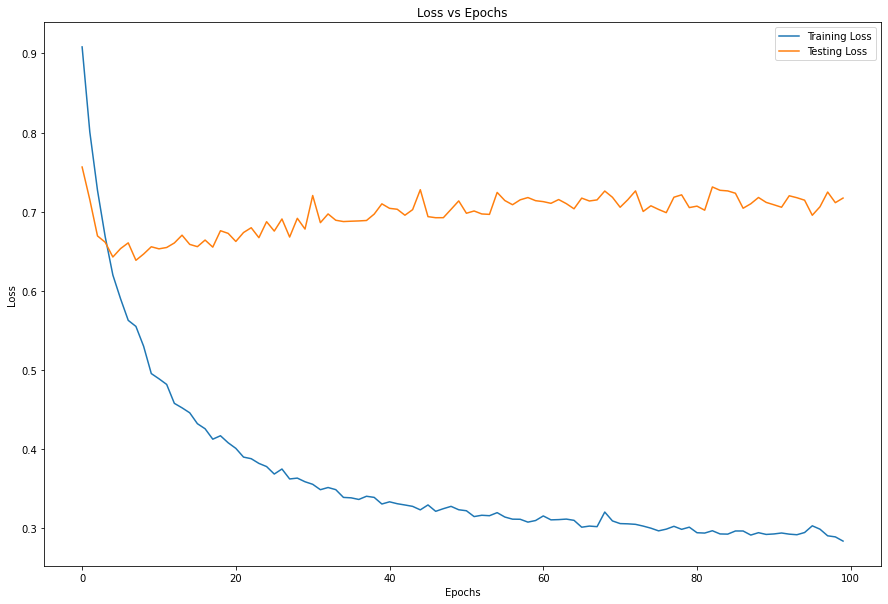



Train Loss: 0.389969
Training Accuracy: 92.125%



Test Loss: 0.656206
Testing Accuracy: 77.488%


Five Samples from Train Dataset


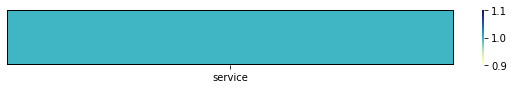

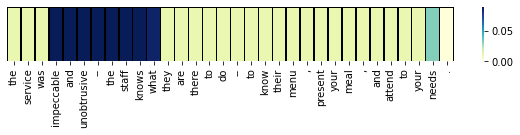

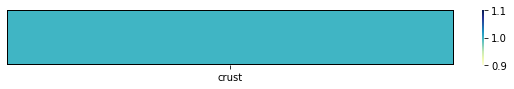

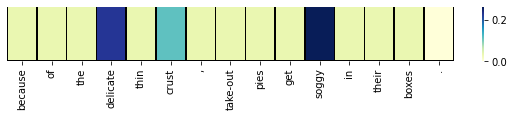

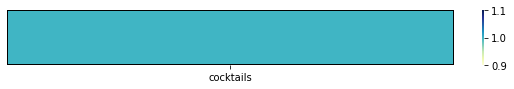

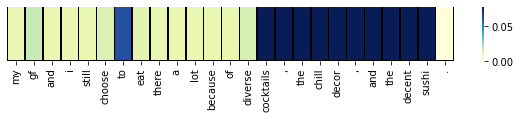

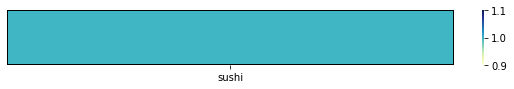

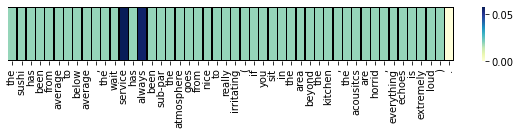

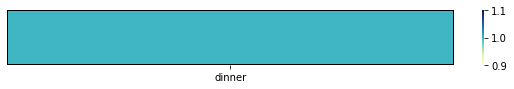

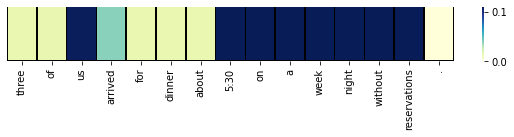

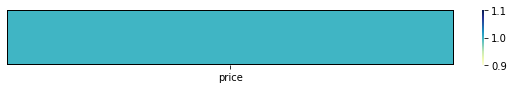

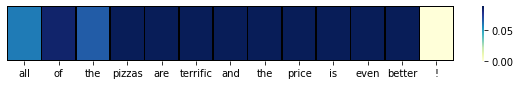

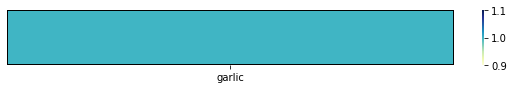

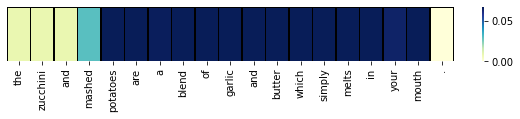

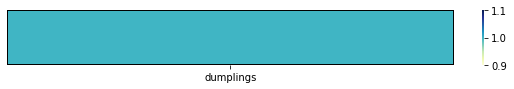

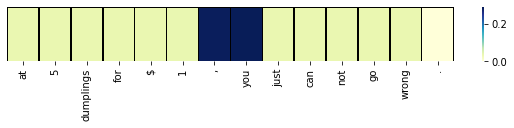

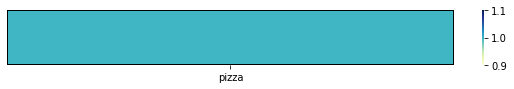

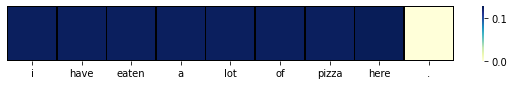

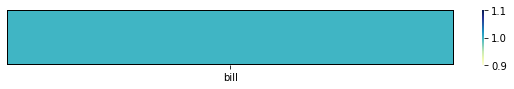

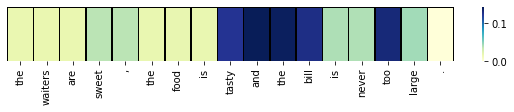

Five Sample from Test Dataset


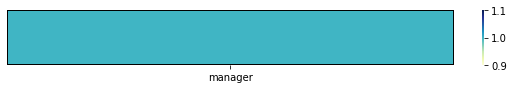

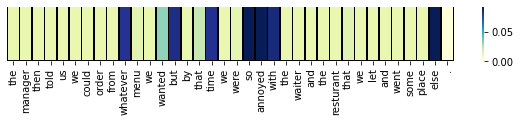

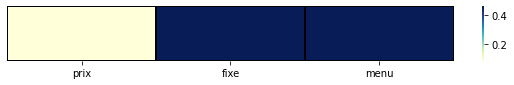

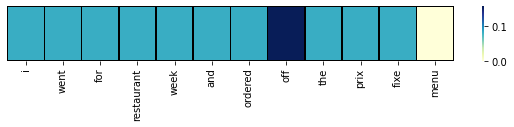

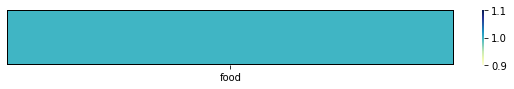

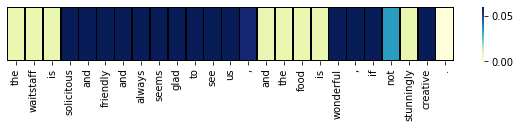

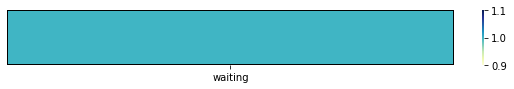

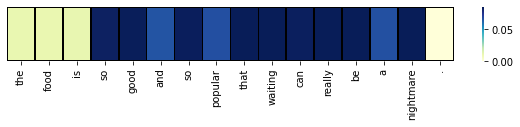

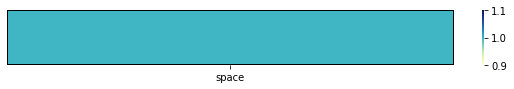

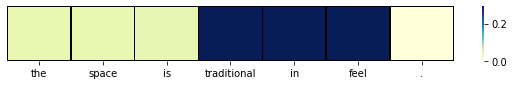

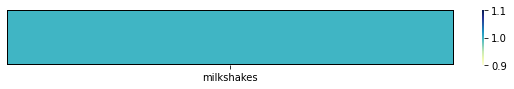

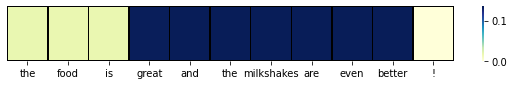

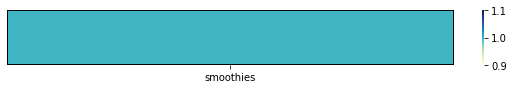

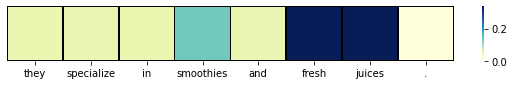

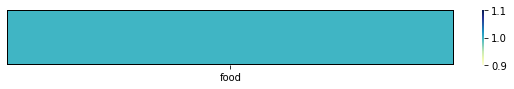

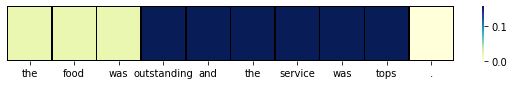

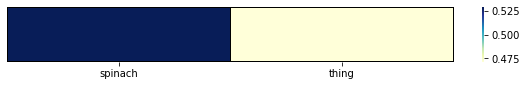

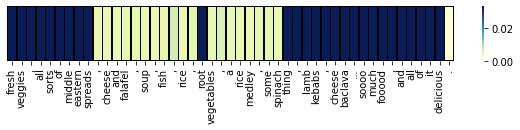

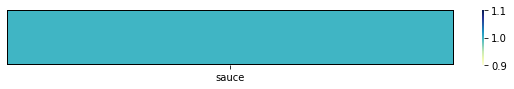

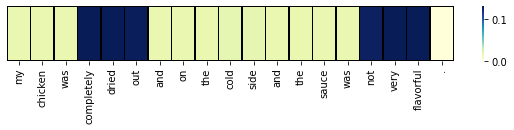

In [ ]:
set_seed(seed_value=42)
ian_model_with_attn, optimizer = initialize_model(pretrained_embedding = r_embedding_matrix,freeze_embedding = False,hidden_dim=300,
                             num_classes=3,dropout=0.5,max_len_context=max_len_context, max_len_target=max_len_target, l2_reg=0.00001,
                             attention_flag=True,learning_rate=0.001)
epoch = 100
training_loss, testing_loss = train(model=ian_model_with_attn, optimizer=optimizer,train_dataloader=r_train_loader,test_dataloader=r_test_loader, epochs=epoch,path='/content/drive/MyDrive/DL/rian_model_with_attn_l2.pth')
ian_model_with_attn = torch.load('/content/drive/MyDrive/DL/rian_model_with_attn_l2.pth')
test_loss, test_accuracy = evaluate(model=ian_model_with_attn,test_dataloader=r_test_loader)
train_loss, train_accuracy = evaluate(model=ian_model_with_attn,test_dataloader=r_train_loader)
plot_loss_curves(path = "/content/drive/MyDrive/DL/rloss-epoch1.jpg", train_loss=training_loss, test_loss=testing_loss, num_of_epochs=epoch)
print('\n')

print(f"Train Loss: {train_loss:.6f}")
print(f"Training Accuracy: {train_accuracy:.3f}%")
print("\n\n")
print(f"Test Loss: {test_loss:.6f}")
print(f"Testing Accuracy: {test_accuracy:.3f}%")
print('\n')

print("Five Samples from Train Dataset")
illustrate_attention_weights(model=ian_model_with_attn, dataloader=r_train_loader, word2idx=word2idx,path="/content/drive/MyDrive/DL/Train/Restaurant/L2")
print("Five Sample from Test Dataset")
illustrate_attention_weights(model=ian_model_with_attn, dataloader=r_test_loader, word2idx=word2idx,path="/content/drive/MyDrive/DL/Test/Restaurant/L2")

Epoch  |  Train Loss  | Train Accuracy | Test Loss  | Test Accuracy |  Elapsed 
--------------------------------------------------------------------------------
  1    |   0.937300   |   58.225575    |  0.782087  | 66.116898  |   1.904  
  2    |   0.783189   |   67.600575    |  0.718451  | 74.074074  |   1.820  
  3    |   0.710829   |   72.099497    |  0.674443  | 75.520833  |   1.861  
  4    |   0.654383   |   75.691451    |  0.676745  | 74.652778  |   1.785  
  5    |   0.623064   |   78.017241    |  0.660903  | 75.954861  |   1.824  
  6    |   0.588526   |   80.468750    |  0.661424  | 75.868056  |   1.747  
  7    |   0.562530   |   81.707974    |  0.659789  | 76.215278  |   1.835  
  8    |   0.542599   |   82.749641    |  0.660887  | 75.607639  |   1.806  
  9    |   0.512671   |   84.985632    |  0.668217  | 74.739583  |   1.776  
  10   |   0.507592   |   84.949713    |  0.668716  | 75.520833  |   1.755  
  11   |   0.495865   |   86.359555    |  0.677950  | 74.479167  |   

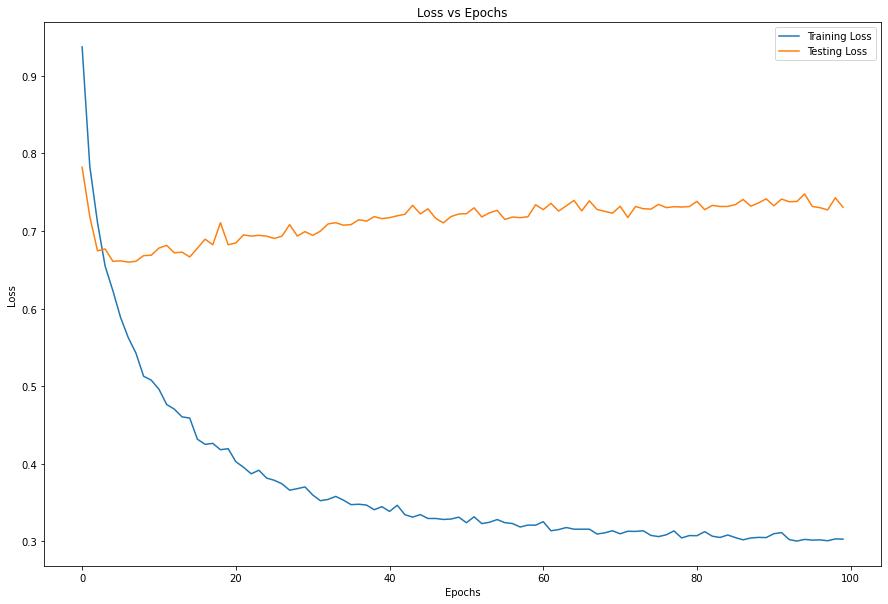

Train Loss: 0.545815
Training Accuracy: 82.826%



Test Loss: 0.515195
Testing Accuracy: 84.968%




In [ ]:
set_seed(seed_value=42)
ian_model_without_attn, optimizer = initialize_model(pretrained_embedding = r_embedding_matrix,freeze_embedding = False,hidden_dim=300,
                             num_classes=3,dropout=0.5,max_len_context=max_len_context, max_len_target=max_len_target, l2_reg=0.00001,
                             attention_flag=False,learning_rate=0.001)
epoch = 100
training_loss, testing_loss = train(model=ian_model_without_attn, optimizer=optimizer,train_dataloader=r_train_loader,test_dataloader=r_test_loader, epochs=epoch,path='/content/drive/MyDrive/DL/rian_model_without_attn_l2.pth')
ian_model_without_attn = torch.load('/content/drive/MyDrive/DL/rian_model_without_attn_l2.pth')
test_loss, test_accuracy = evaluate(model=ian_model_without_attn,test_dataloader=r_test_loader)
test_loss, test_accuracy = evaluate(model=ian_model_without_attn,test_dataloader=r_train_loader)
plot_loss_curves(path = "/content/drive/MyDrive/DL/rloss-epoch2.jpg", train_loss=training_loss, test_loss=testing_loss, num_of_epochs=epoch)

print(f"Train Loss: {train_loss:.6f}")
print(f"Training Accuracy: {train_accuracy:.3f}%")
print("\n\n")
print(f"Test Loss: {test_loss:.6f}")
print(f"Testing Accuracy: {test_accuracy:.3f}%")
print('\n')

## Laptop Dataset

In [22]:
l_train_context, l_train_target, l_train_polarity = np.array(laptop_train['context']), np.array(laptop_train['target']), np.array(laptop_train['polarity'])
l_test_context, l_test_target, l_test_polarity = np.array(laptop_test['context']), np.array(laptop_test['target']), np.array(laptop_test['polarity'])

In [23]:
ltrain_tokenized_context, ltrain_tokenized_target,ltrain_context_lens, ltrain_target_lens, ltest_tokenized_context, ltest_tokenized_target,ltest_context_lens, ltest_target_lens, lword2idx, lmax_len_context, lmax_len_target = tokenize_and_build_vocabulary(l_train_context, l_train_target, l_test_context, l_test_target)
ltrain_encoded_context = encode_tokenized_text(ltrain_tokenized_context, lword2idx, lmax_len_context)
ltest_encoded_context = encode_tokenized_text(ltest_tokenized_context, lword2idx, lmax_len_context)
ltrain_encoded_target = encode_tokenized_text(ltrain_tokenized_target, lword2idx, lmax_len_target)
ltest_encoded_target = encode_tokenized_text(ltest_tokenized_target, lword2idx, lmax_len_target)
l_embedding_matrix = load_pretrained_vectors(lword2idx,embedding,300)
l_embedding_matrix = torch.tensor(l_embedding_matrix)

There are 3465/3605 pretrained vectors found


In [24]:
l_train_dataset = ABSADataset(ltrain_encoded_context, ltrain_encoded_target, l_train_polarity,ltrain_context_lens, ltrain_target_lens,lmax_len_context, lmax_len_target)
l_train_loader = DataLoader(dataset=l_train_dataset, batch_size=128, shuffle=True, num_workers=2)

In [25]:
l_test_dataset = ABSADataset(ltest_encoded_context, ltest_encoded_target, l_test_polarity,ltest_context_lens, ltest_target_lens,lmax_len_context, lmax_len_target)
l_test_loader = DataLoader(dataset=l_test_dataset, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

Epoch  |  Train Loss  | Train Accuracy | Test Loss  | Test Accuracy |  Elapsed 
--------------------------------------------------------------------------------
  1    |   0.995743   |   54.070724    |  0.901988  | 57.038690  |   1.713  
  2    |   0.845353   |   63.569079    |  0.817660  | 63.330853  |   1.627  
  3    |   0.770169   |   69.490132    |  0.801936  | 65.520833  |   1.612  
  4    |   0.700497   |   73.314145    |  0.791079  | 66.629464  |   1.620  
  5    |   0.680364   |   74.753289    |  0.818341  | 65.024802  |   1.558  
  6    |   0.649696   |   77.384868    |  0.845034  | 63.809524  |   1.548  
  7    |   0.629610   |   78.303180    |  0.796210  | 67.688492  |   1.596  
  8    |   0.580127   |   80.893640    |  0.767882  | 69.117063  |   1.609  
  9    |   0.547441   |   83.031798    |  0.764259  | 68.797123  |   1.544  
  10   |   0.546949   |   82.976974    |  0.789339  | 68.028274  |   1.564  
  11   |   0.504439   |   85.608553    |  0.756115  | 68.184524  |   

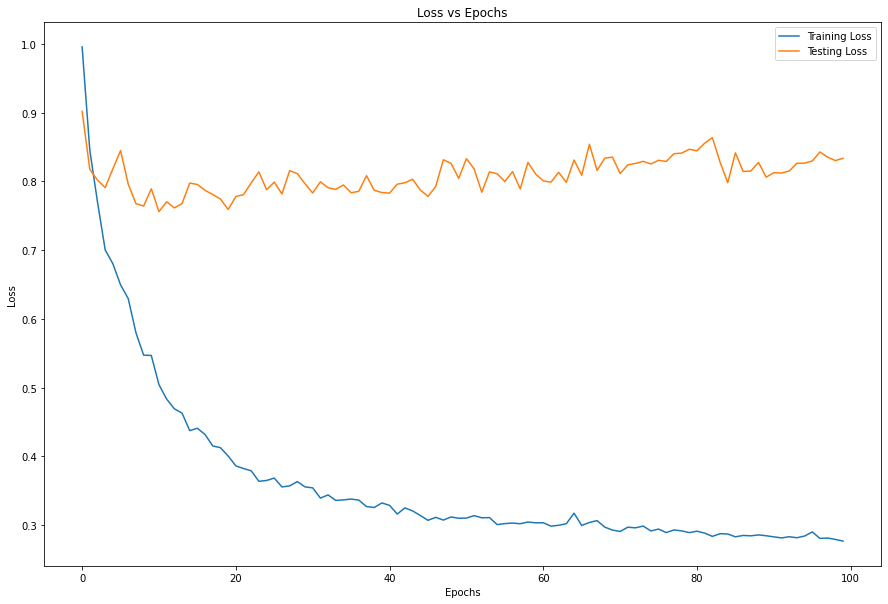



Train Loss: 0.289356
Training Accuracy: 97.574%



Test Loss: 0.778522
Testing Accuracy: 70.531%


Five Samples from Train Dataset


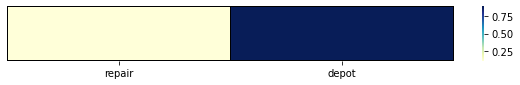

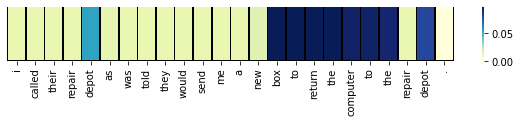

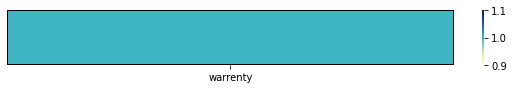

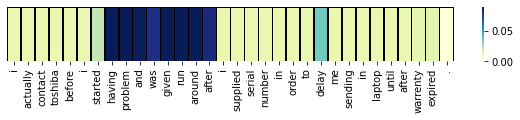

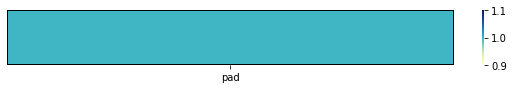

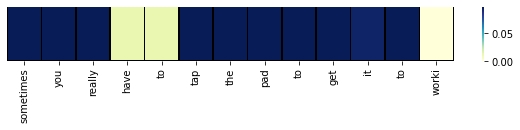

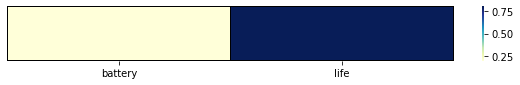

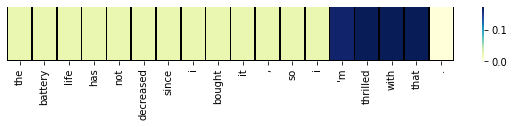

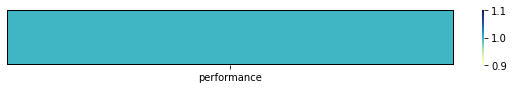

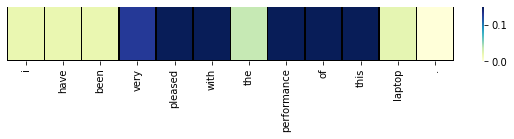

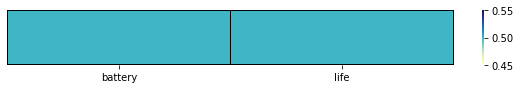

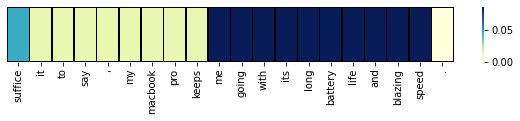

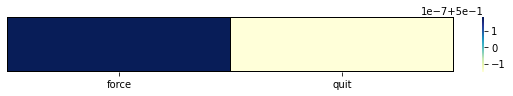

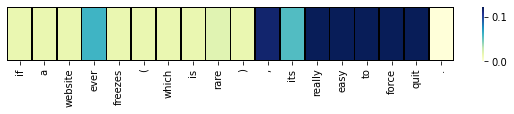

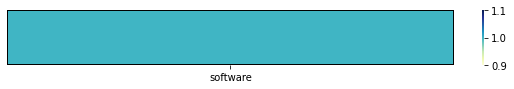

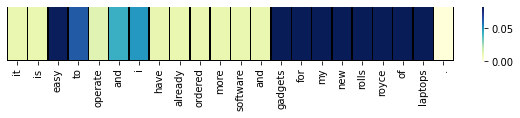

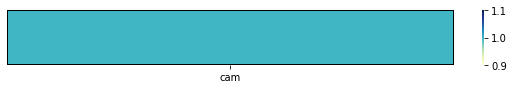

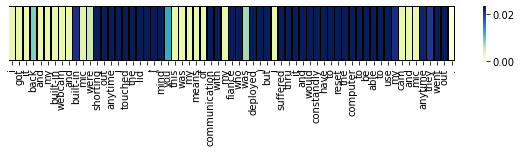

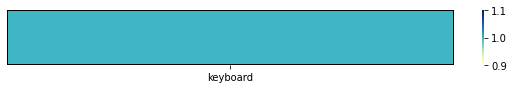

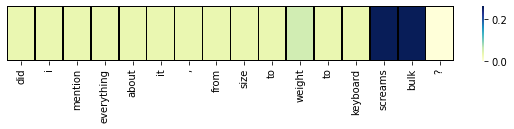

Five Sample from Test Dataset


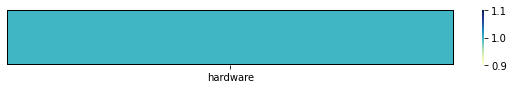

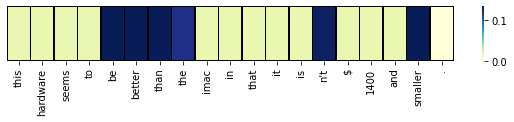

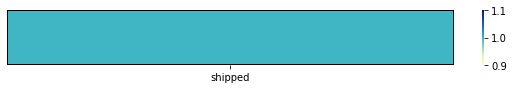

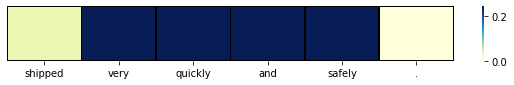

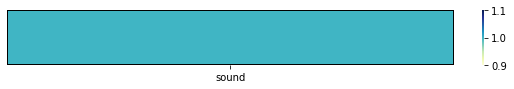

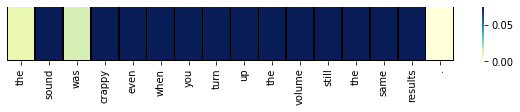

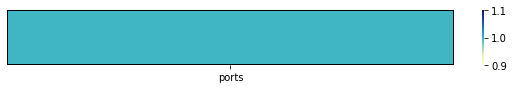

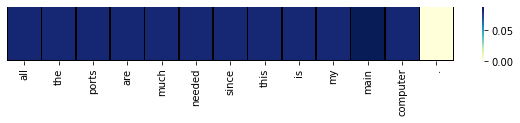

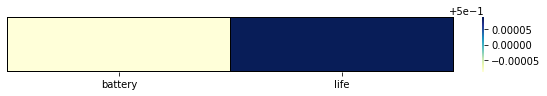

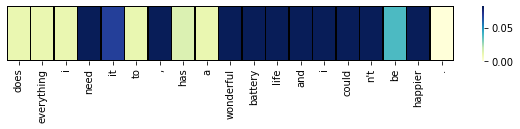

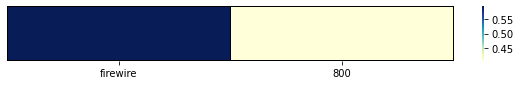

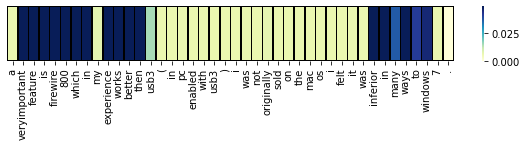

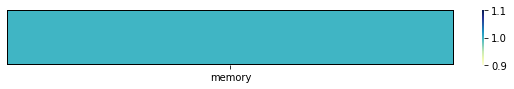

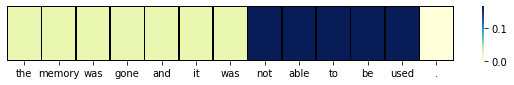

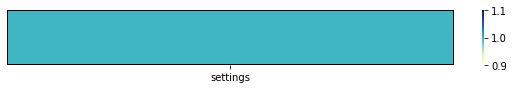

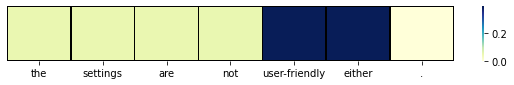

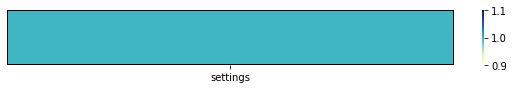

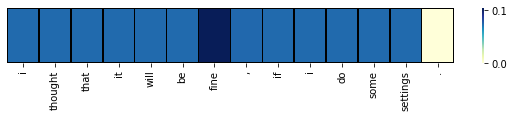

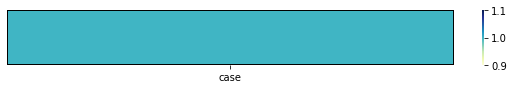

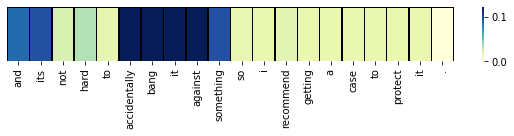

In [ ]:
set_seed(seed_value=42)
lian_model_with_attn, optimizer = initialize_model(pretrained_embedding = l_embedding_matrix,freeze_embedding = False,hidden_dim=300,
                             num_classes=3,dropout=0.5,max_len_context=lmax_len_context, max_len_target=lmax_len_target, l2_reg=0,
                             attention_flag=True,learning_rate=0.001)
epoch = 100
ltraining_loss, ltesting_loss = train(model=lian_model_with_attn, optimizer=optimizer,train_dataloader=l_train_loader,test_dataloader=l_test_loader, epochs=epoch,path="/content/drive/MyDrive/DL/lian_model_with_attn.pth")
lian_model_with_attn = torch.load('/content/drive/MyDrive/DL/lian_model_with_attn.pth')
test_loss, test_accuracy = evaluate(model=lian_model_with_attn,test_dataloader=l_test_loader)
train_loss, train_accuracy = evaluate(model=lian_model_with_attn,test_dataloader=l_train_loader)
plot_loss_curves(path = "/content/drive/MyDrive/DL/lloss-epoch1.jpg", train_loss=ltraining_loss, test_loss=ltesting_loss, num_of_epochs=epoch)
print('\n')

print(f"Train Loss: {train_loss:.6f}")
print(f"Training Accuracy: {train_accuracy:.3f}%")
print("\n\n")
print(f"Test Loss: {test_loss:.6f}")
print(f"Testing Accuracy: {test_accuracy:.3f}%")
print('\n')

print("Five Samples from Train Dataset")
illustrate_attention_weights(model=lian_model_with_attn, dataloader=l_train_loader, word2idx=lword2idx,path="/content/drive/MyDrive/DL/Train/Laptop")
print("Five Sample from Test Dataset")
illustrate_attention_weights(model=lian_model_with_attn, dataloader=l_test_loader, word2idx=lword2idx,path="/content/drive/MyDrive/DL/Test/Laptop")


Epoch  |  Train Loss  | Train Accuracy | Test Loss  | Test Accuracy |  Elapsed 
--------------------------------------------------------------------------------
  1    |   0.996066   |   55.180921    |  0.898223  | 58.149802  |   1.598  
  2    |   0.835171   |   64.871162    |  0.816958  | 62.388393  |   1.495  
  3    |   0.753136   |   71.175987    |  0.814485  | 63.328373  |   1.492  
  4    |   0.721518   |   71.833882    |  0.805761  | 63.645833  |   1.481  
  5    |   0.662456   |   75.274123    |  0.771505  | 66.130952  |   1.491  
  6    |   0.616772   |   78.303180    |  0.775873  | 66.765873  |   1.511  
  7    |   0.594344   |   80.235746    |  0.774529  | 65.508433  |   1.434  
  8    |   0.582934   |   80.852522    |  0.740990  | 68.355655  |   1.472  
  9    |   0.562695   |   82.058662    |  0.767435  | 69.288194  |   1.489  
  10   |   0.531855   |   84.032346    |  0.814548  | 65.654762  |   1.470  
  11   |   0.528200   |   83.621162    |  0.781025  | 67.562004  |   

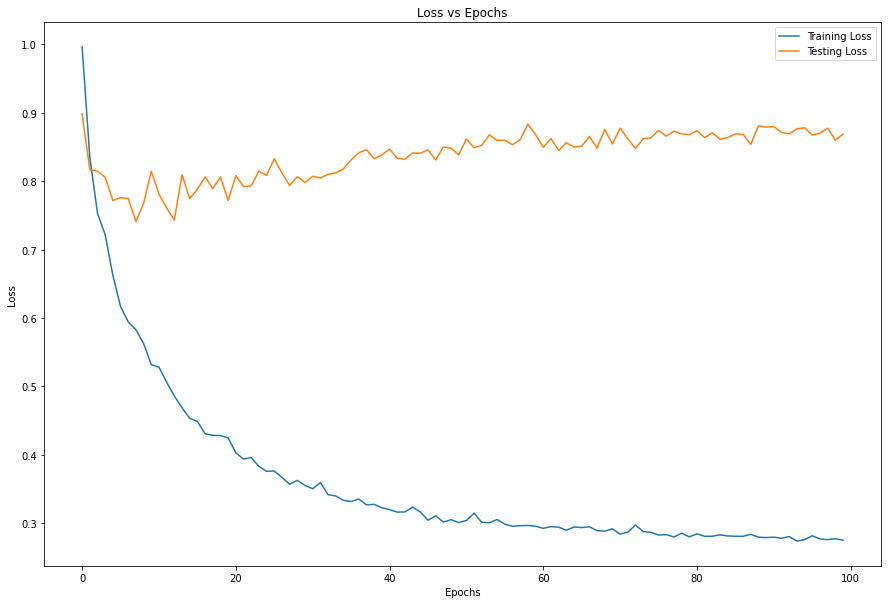



Train Loss: 0.501443
Training Accuracy: 85.567%



Test Loss: 0.767904
Testing Accuracy: 69.263%




In [ ]:
set_seed(seed_value=42)
lian_model_without_attn, optimizer = initialize_model(pretrained_embedding = l_embedding_matrix,freeze_embedding = False,hidden_dim=300,
                             num_classes=3,dropout=0.5,max_len_context=lmax_len_context, max_len_target=lmax_len_target, l2_reg=0,
                             attention_flag=False,learning_rate=0.001)
epoch = 100
ltraining_loss, ltesting_loss = train(model=lian_model_without_attn, optimizer=optimizer,train_dataloader=l_train_loader,test_dataloader=l_test_loader, epochs=epoch,path="/content/drive/MyDrive/DL/lian_model_without_attn.pth")
lian_model_without_attn = torch.load('/content/drive/MyDrive/DL/lian_model_without_attn.pth')
test_loss, test_accuracy = evaluate(model=lian_model_without_attn,test_dataloader=l_test_loader)
train_loss, train_accuracy = evaluate(model=lian_model_without_attn,test_dataloader=l_train_loader)
plot_loss_curves(path = "/content/drive/MyDrive/DL/lloss-epoch2.jpg", train_loss=ltraining_loss, test_loss=ltesting_loss, num_of_epochs=epoch)
print('\n')

print(f"Train Loss: {train_loss:.6f}")
print(f"Training Accuracy: {train_accuracy:.3f}%")
print("\n\n")
print(f"Test Loss: {test_loss:.6f}")
print(f"Testing Accuracy: {test_accuracy:.3f}%")
print('\n')


Epoch  |  Train Loss  | Train Accuracy | Test Loss  | Test Accuracy |  Elapsed 
--------------------------------------------------------------------------------
  1    |   0.996502   |   54.111842    |  0.903006  | 56.882440  |   1.699  
  2    |   0.858639   |   63.034539    |  0.817304  | 64.117063  |   1.626  
  3    |   0.773498   |   68.681469    |  0.791633  | 65.515873  |   1.633  
  4    |   0.698495   |   73.355263    |  0.834949  | 63.970734  |   1.593  
  5    |   0.681667   |   75.424890    |  0.792229  | 65.815972  |   1.626  
  6    |   0.643787   |   77.412281    |  0.797861  | 65.223214  |   1.552  
  7    |   0.608306   |   79.194079    |  0.793276  | 67.378472  |   1.639  
  8    |   0.576418   |   81.633772    |  0.795979  | 66.614583  |   1.570  
  9    |   0.551814   |   83.045504    |  0.776791  | 68.028274  |   1.632  
  10   |   0.558486   |   82.305373    |  0.784705  | 67.088294  |   1.567  
  11   |   0.511335   |   85.293311    |  0.765245  | 68.501984  |   

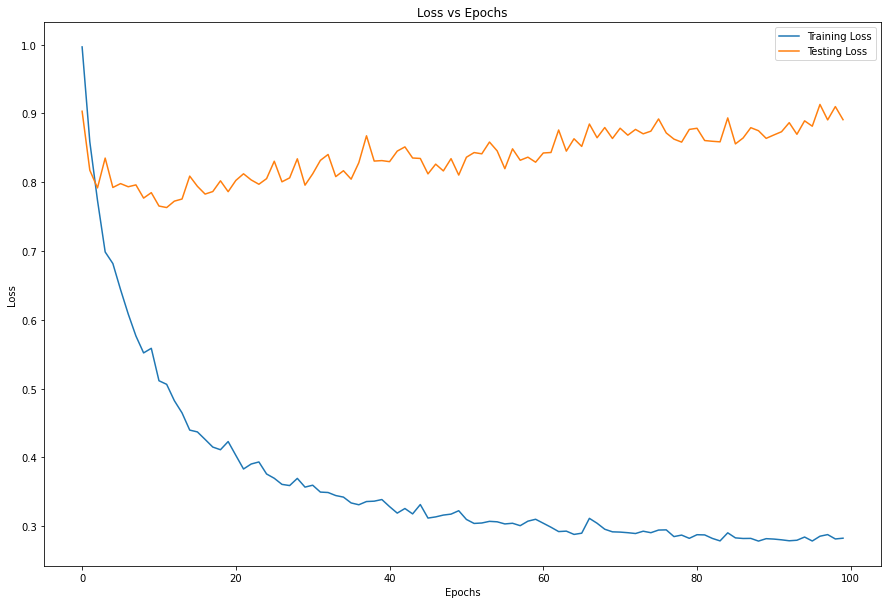



Train Loss: 0.329667
Training Accuracy: 95.518%



Test Loss: 0.795274
Testing Accuracy: 68.978%


Five Samples from Train Dataset


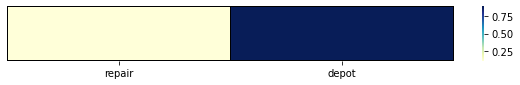

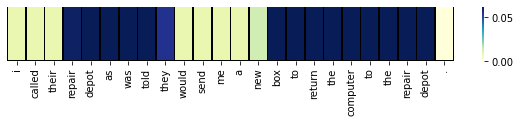

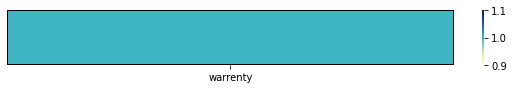

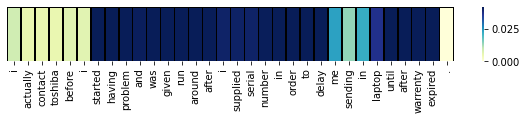

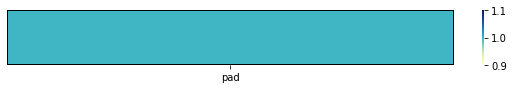

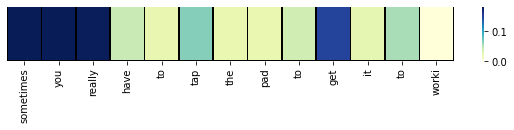

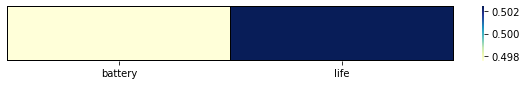

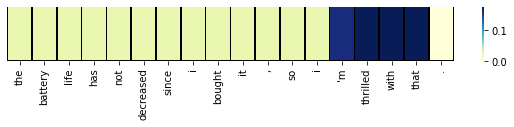

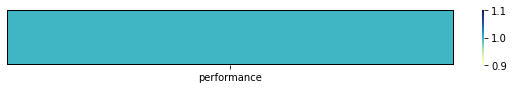

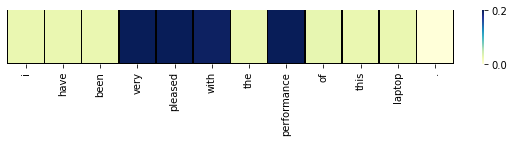

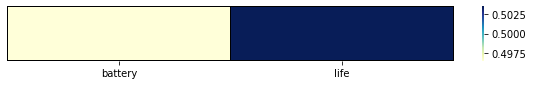

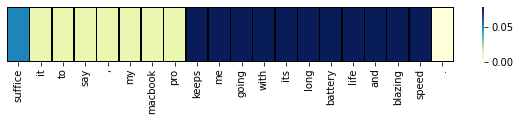

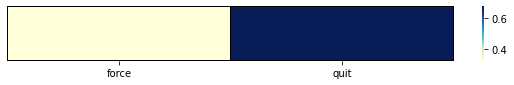

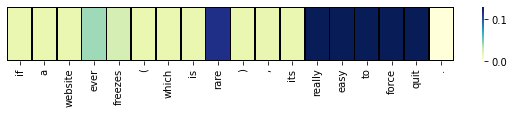

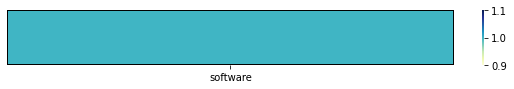

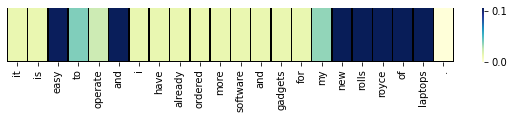

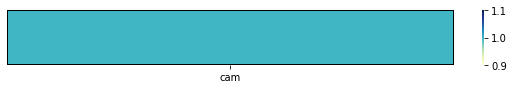

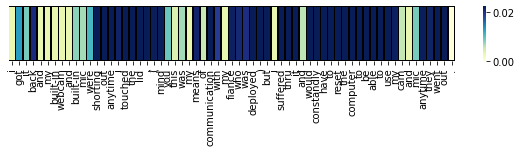

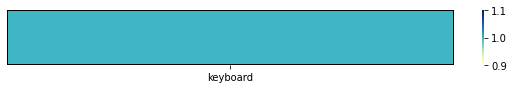

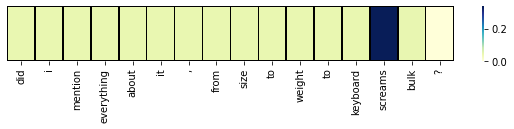

Five Sample from Test Dataset


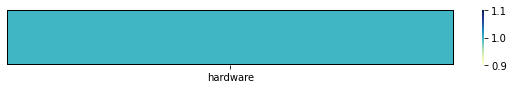

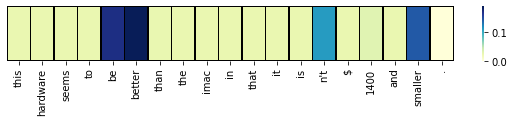

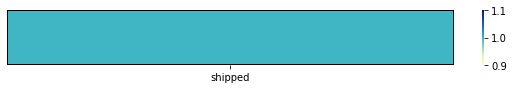

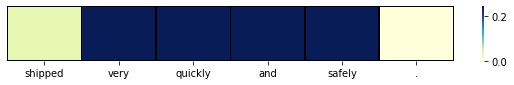

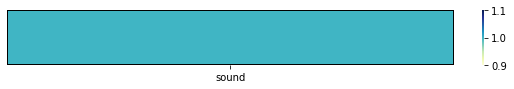

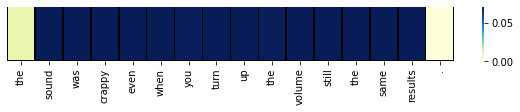

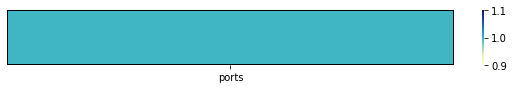

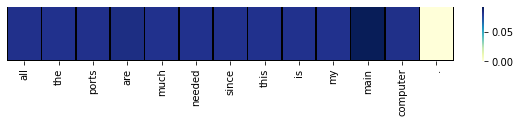

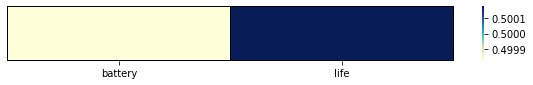

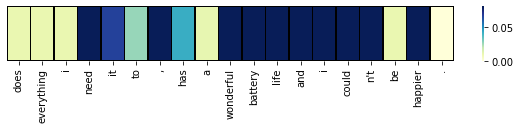

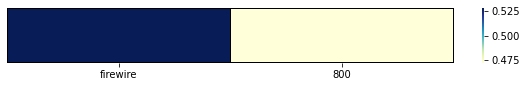

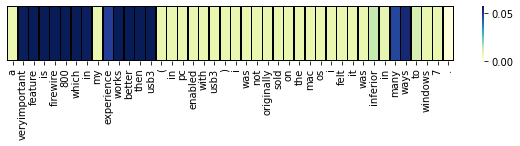

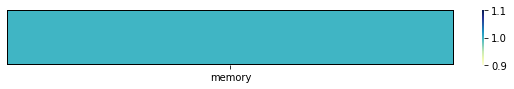

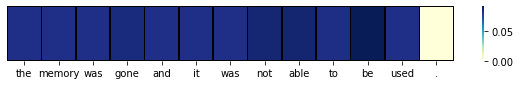

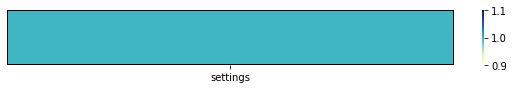

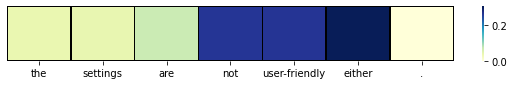

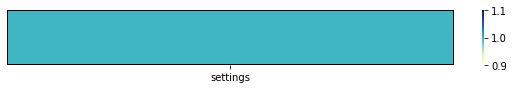

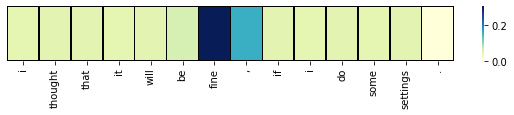

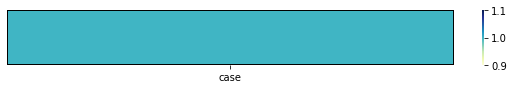

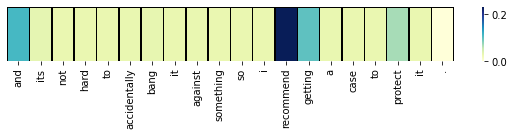

In [ ]:
set_seed(seed_value=42)
lian_model_with_attn, optimizer = initialize_model(pretrained_embedding = l_embedding_matrix,freeze_embedding = False,hidden_dim=300,
                             num_classes=3,dropout=0.5,max_len_context=lmax_len_context, max_len_target=lmax_len_target, l2_reg=0.00001,
                             attention_flag=True,learning_rate=0.001)
epoch = 100
ltraining_loss, ltesting_loss = train(model=lian_model_with_attn, optimizer=optimizer,train_dataloader=l_train_loader,test_dataloader=l_test_loader, epochs=epoch,path="/content/drive/MyDrive/DL/lian_model_with_attn_l2.pth")
lian_model_with_attn = torch.load('/content/drive/MyDrive/DL/lian_model_with_attn_l2.pth')
test_loss, test_accuracy = evaluate(model=lian_model_with_attn,test_dataloader=l_test_loader)
train_loss, train_accuracy = evaluate(model=lian_model_with_attn,test_dataloader=l_train_loader)
plot_loss_curves(path = "/content/drive/MyDrive/DL/lloss-epoch1.jpg", train_loss=ltraining_loss, test_loss=ltesting_loss, num_of_epochs=epoch)
print('\n')

print(f"Train Loss: {train_loss:.6f}")
print(f"Training Accuracy: {train_accuracy:.3f}%")
print("\n\n")
print(f"Test Loss: {test_loss:.6f}")
print(f"Testing Accuracy: {test_accuracy:.3f}%")
print('\n')

print("Five Samples from Train Dataset")
illustrate_attention_weights(model=lian_model_with_attn, dataloader=l_train_loader, word2idx=lword2idx,path="/content/drive/MyDrive/DL/Train/Laptop/L2")
print("Five Sample from Test Dataset")
illustrate_attention_weights(model=lian_model_with_attn, dataloader=l_test_loader, word2idx=lword2idx,path="/content/drive/MyDrive/DL/Test/Laptop/L2")

Epoch  |  Train Loss  | Train Accuracy | Test Loss  | Test Accuracy |  Elapsed 
--------------------------------------------------------------------------------
  1    |   0.996836   |   55.057566    |  0.899167  | 57.993552  |   1.635  
  2    |   0.838732   |   64.953399    |  0.821077  | 61.763393  |   1.518  
  3    |   0.760216   |   69.942434    |  0.818058  | 63.494544  |   1.503  
  4    |   0.746462   |   70.476974    |  0.822557  | 64.432044  |   1.665  
  5    |   0.673670   |   74.794408    |  0.773492  | 65.195933  |   1.512  
  6    |   0.620427   |   78.467654    |  0.797636  | 65.662202  |   1.504  
  7    |   0.601827   |   79.714912    |  0.774420  | 65.987103  |   1.488  
  8    |   0.582642   |   80.715461    |  0.751715  | 69.456845  |   1.499  
  9    |   0.557545   |   81.935307    |  0.793865  | 67.876984  |   1.458  
  10   |   0.536856   |   83.744518    |  0.809076  | 64.714782  |   1.500  
  11   |   0.528137   |   83.621162    |  0.787222  | 66.614583  |   

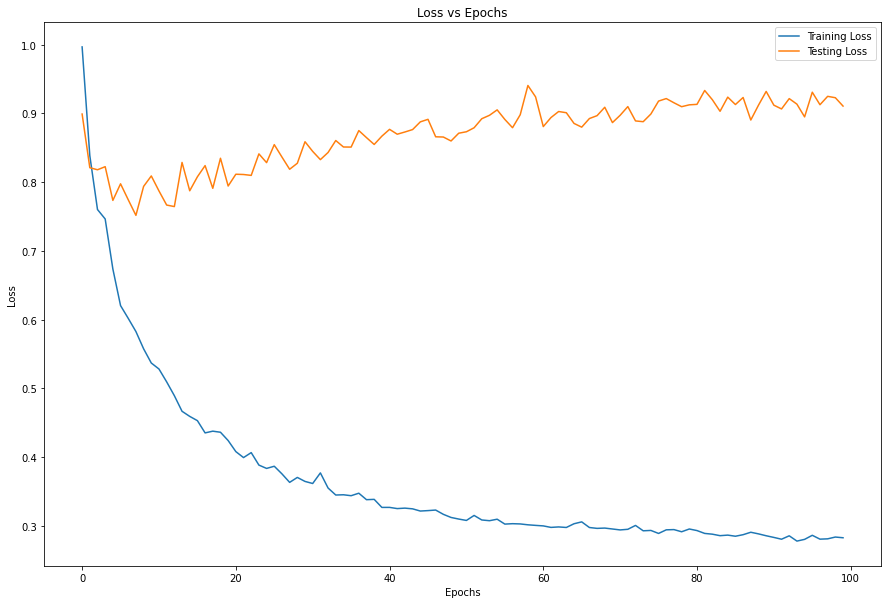



Train Loss: 0.545815
Training Accuracy: 82.826%



Test Loss: 0.752366
Testing Accuracy: 69.410%




In [ ]:
set_seed(seed_value=42)
lian_model_without_attn, optimizer = initialize_model(pretrained_embedding = l_embedding_matrix,freeze_embedding = False,hidden_dim=300,
                             num_classes=3,dropout=0.5,max_len_context=lmax_len_context, max_len_target=lmax_len_target, l2_reg=0.00001,
                             attention_flag=False,learning_rate=0.001)
epoch = 100
ltraining_loss, ltesting_loss = train(model=lian_model_without_attn, optimizer=optimizer,train_dataloader=l_train_loader,test_dataloader=l_test_loader, epochs=epoch,path="/content/drive/MyDrive/DL/lian_model_without_attn_l2.pth")
lian_model_without_attn = torch.load('/content/drive/MyDrive/DL/lian_model_without_attn_l2.pth')
test_loss, test_accuracy = evaluate(model=lian_model_without_attn,test_dataloader=l_test_loader)
train_loss, train_accuracy = evaluate(model=lian_model_without_attn,test_dataloader=l_train_loader)
plot_loss_curves(path = "/content/drive/MyDrive/DL/lloss-epoch2.jpg", train_loss=ltraining_loss, test_loss=ltesting_loss, num_of_epochs=epoch)
print('\n')

print(f"Train Loss: {train_loss:.6f}")
print(f"Training Accuracy: {train_accuracy:.3f}%")
print("\n\n")
print(f"Test Loss: {test_loss:.6f}")
print(f"Testing Accuracy: {test_accuracy:.3f}%")
print('\n')

## Test

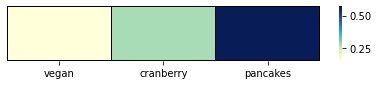

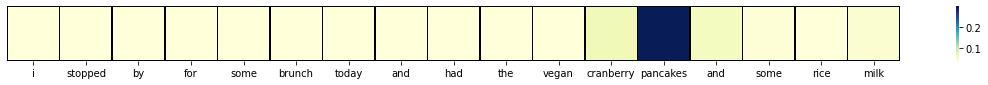

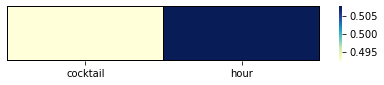

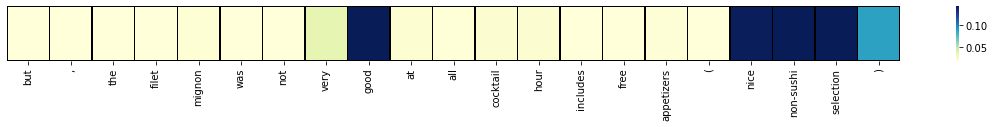

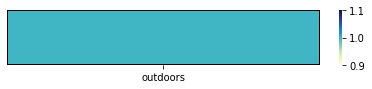

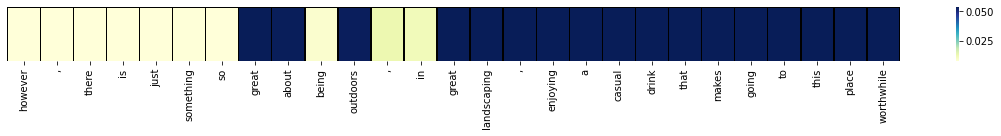

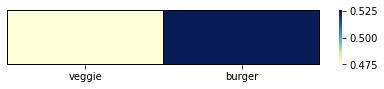

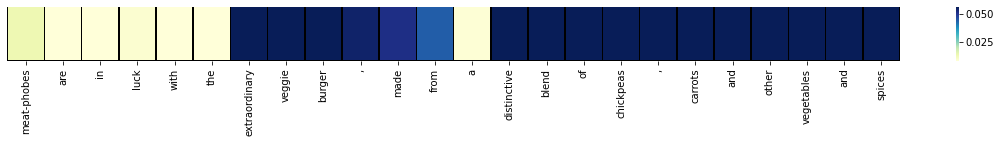

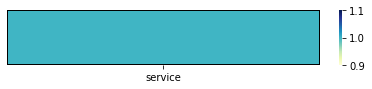

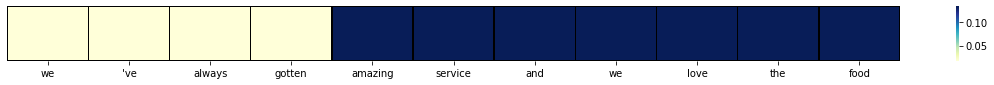

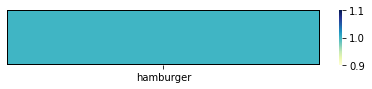

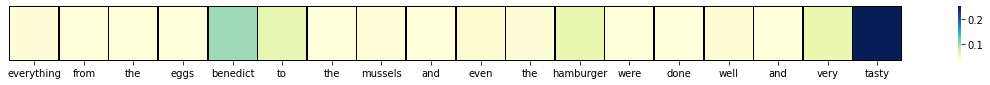

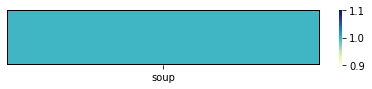

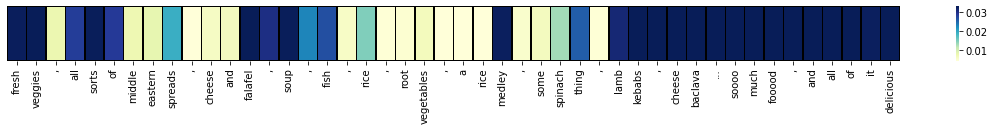

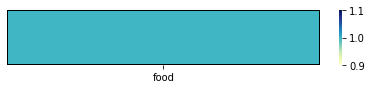

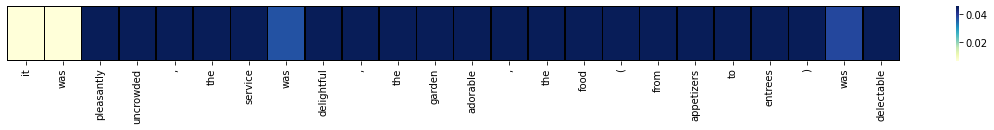

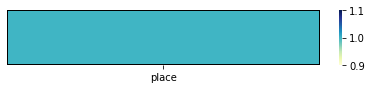

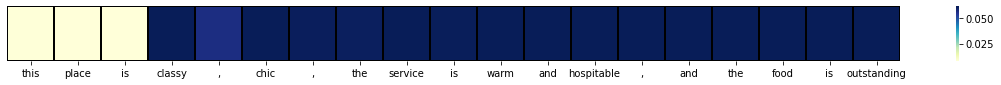

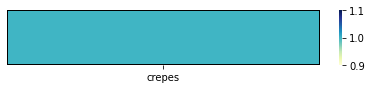

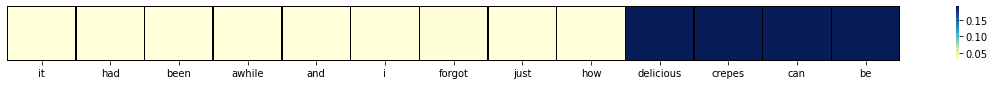



                     Context                       |   Target   |  Output  | True Label
------------------------------------------------------------------------------------------------------------------------
the comments about fried foods is correct ( below ) but the other dishes , including the lamb entree and many of the salads ( avocado shrimp ) were quite good | fried foods | positive | negative

great food , great waitstaff , great atmosphere , and best of all great beer | atmosphere | positive | positive

while there 's a decent menu , it should n't take ten minutes to get your drinks and 45 for a dessert pizza | dessert pizza | neutral  | neutral 

it is a hidden delight complete with a quaint bar and good food |    food    | positive | positive

thick fries , meaty chili and stuffed baked potatoes round out a menu that includes a cool , ultra-thick chocolate frosty | chocolate frosty | positive | positive

it is a cozy place to go with a couple of friends  |   place    | pos

In [47]:
model = torch.load('/content/drive/MyDrive/DL/rian_model_with_attn.pth')
illustrate_attention_weights(model=model, dataloader=r_test_loader, word2idx=word2idx,path="attn")
display_prediction(model=model, dataloader=r_test_loader, word2idx=word2idx)

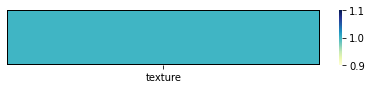

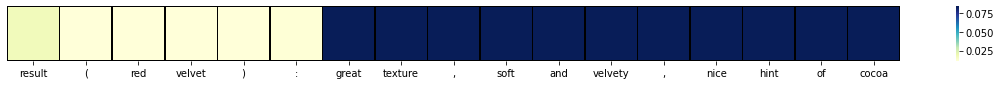

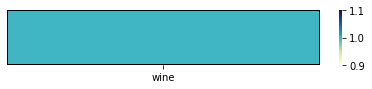

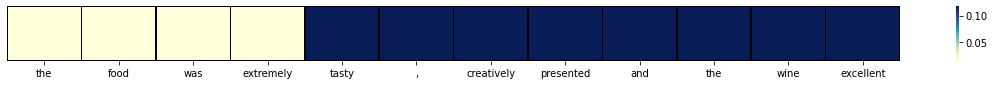

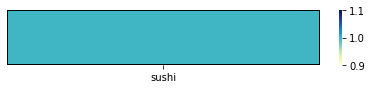

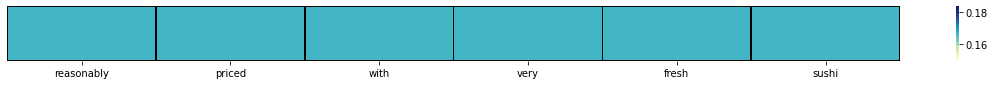

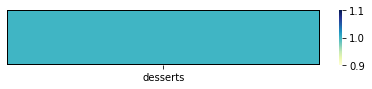

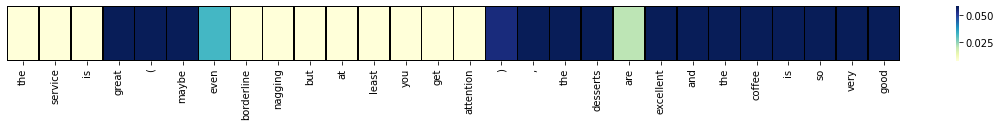

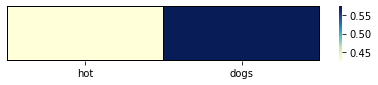

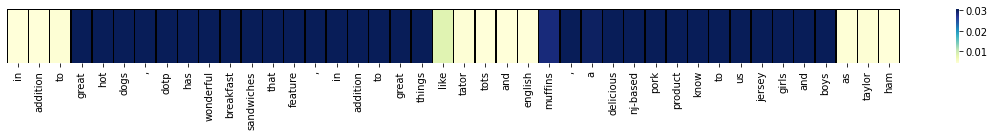

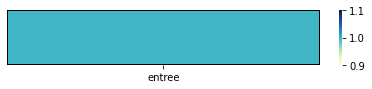

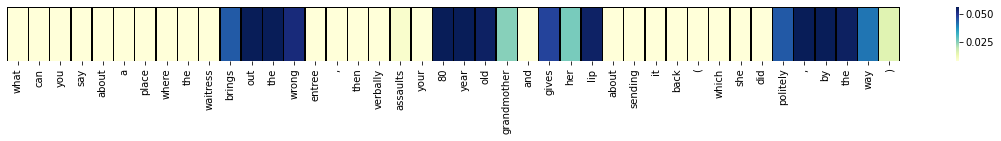

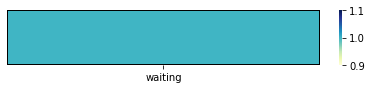

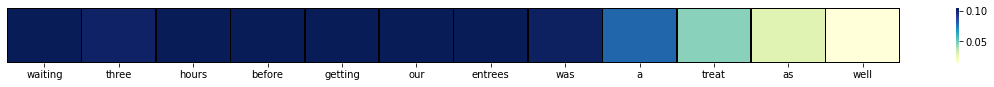

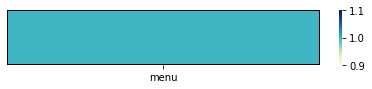

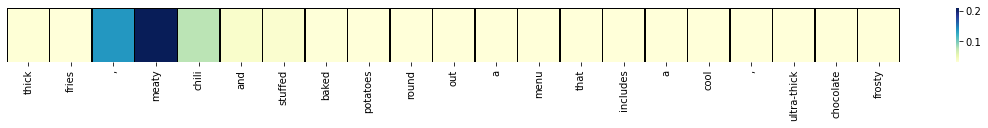

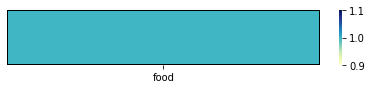

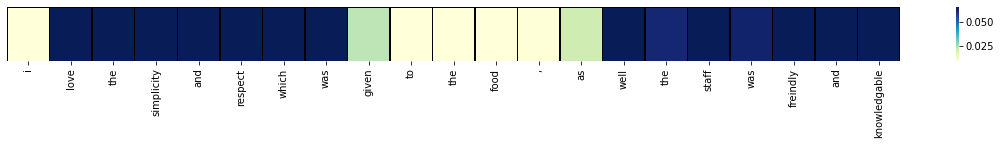

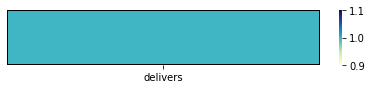

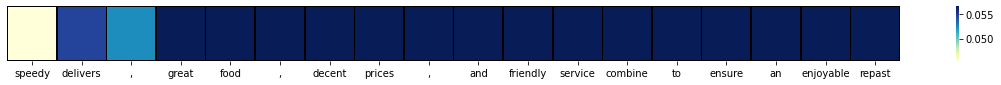



                     Context                       |   Target   |  Output  | True Label
------------------------------------------------------------------------------------------------------------------------
the portions are very large and the service is fantastic ! |  service   | positive | positive

it does n't look like much on the outside , but the minute you walk inside , it 's a whole other atmosphere |  outside   | negative | negative

if you 're in the neighborhood , definitely stop by for a great meal |    meal    | positive | positive

the teas are great and all the sweets are homemade |   sweets   | positive | positive

the dinner menu offers a variety of great entrees , including fresh seafood and huge steaks , there 's also a couple of non-meat alternatives |   steaks   | positive | positive

somewhat disappointing wine list ( only new vintages | wine list  | negative | negative

the comments about fried foods is correct ( below ) but the other dishes , including the la

In [52]:
model = torch.load('/content/drive/MyDrive/DL/rian_model_with_attn_l2.pth')
illustrate_attention_weights(model=model, dataloader=r_test_loader, word2idx=word2idx,path="attn")
display_prediction(model=model, dataloader=r_test_loader, word2idx=word2idx)

In [53]:
model = torch.load('/content/drive/MyDrive/DL/rian_model_without_attn.pth')
display_prediction(model=model, dataloader=r_test_loader, word2idx=word2idx)



                     Context                       |   Target   |  Output  | True Label
------------------------------------------------------------------------------------------------------------------------
intimate but charming interior with extremely friendly and attentive service |  interior  | positive | positive

their twist on pizza is heatlhy , but full of flavor | twist on pizza | positive | positive

my chelsea 's impressive and creative menu includes modern , westernized japanese dishes such as foie gras unagi napolean , jap style hamburger steak , spicy cod roe spaghetti , black cod with miso base , and rack of lamb in black truffle sauce , to name a few | spicy cod roe spaghetti | positive | neutral 

if you want good tasting , well seasoned latin food eat at cabana and you ca n't go wrong | latin food | positive | positive

this place has the strangest menu and the restaurants tries too hard to make fancy food |    menu    | positive | negative

 we had tons of great f

In [56]:
model = torch.load('/content/drive/MyDrive/DL/rian_model_without_attn_l2.pth')
display_prediction(model=model, dataloader=r_test_loader, word2idx=word2idx)



                     Context                       |   Target   |  Output  | True Label
------------------------------------------------------------------------------------------------------------------------
great food , great waitstaff , great atmosphere , and best of all great beer | atmosphere | positive | positive

     i was pleasently surprised at the taste       |   taste    | positive | positive

the food was excellent - authentic italian cuisine made absolutely fresh | italian cuisine | positive | positive

excellent tapas at great prices , romantic , small but not overly crowed , |   tapas    | positive | positive

a small , outdoor eating area makes for a private , comfortable space to study alone or meet up with friends | outdoor eating area | positive | positive

i stopped by for some brunch today and had the vegan cranberry pancakes and some rice milk |   brunch   | neutral  | neutral 

             try the homemade breads               | homemade breads | positive | p

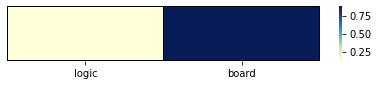

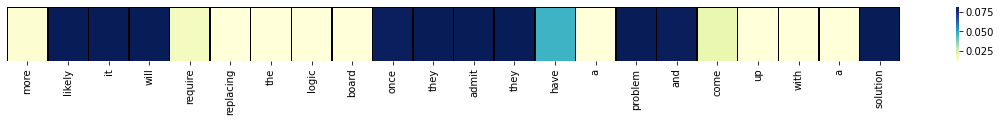

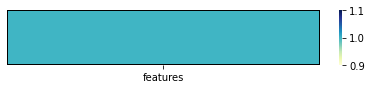

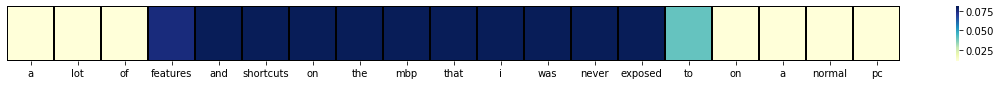

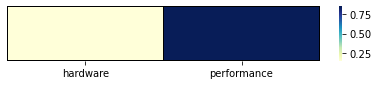

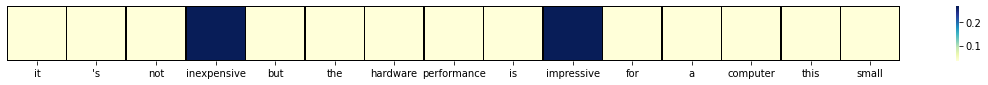

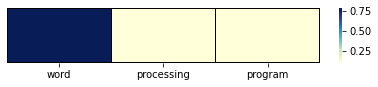

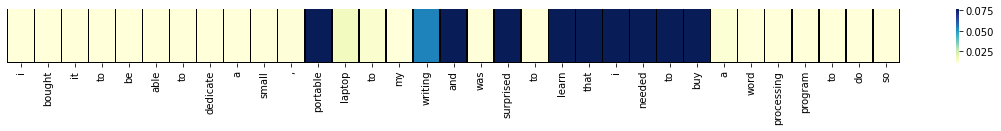

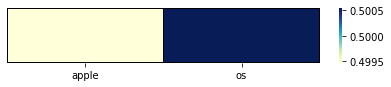

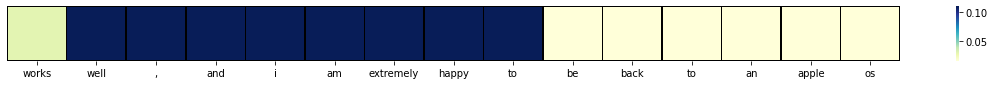

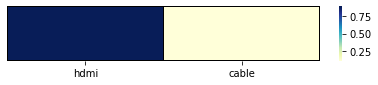

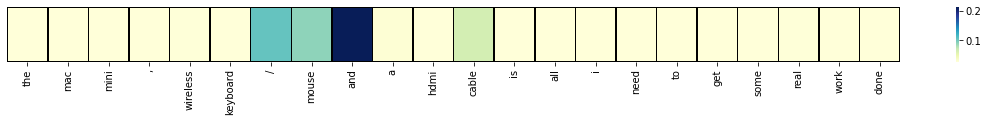

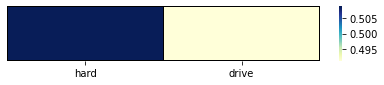

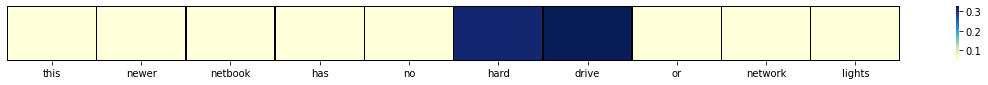

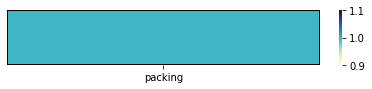

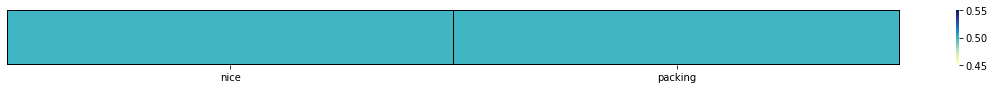

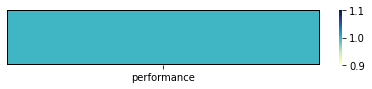

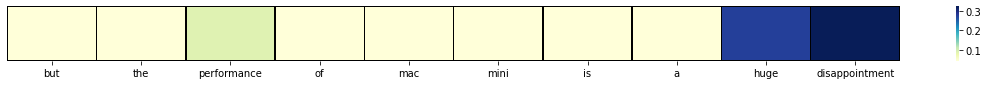

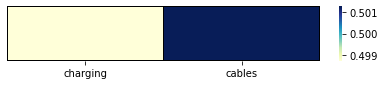

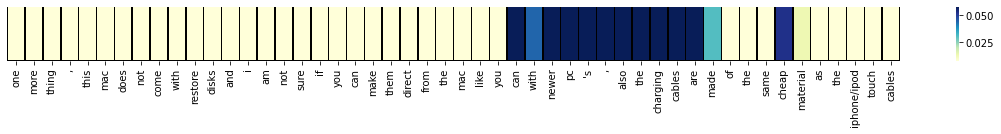



                     Context                       |   Target   |  Output  | True Label
------------------------------------------------------------------------------------------------------------------------
then the system would many times not power down without a forced power-off |   system   | negative | negative

the first time i used the card reader it took half an hour and a pair of tweezers to remove the card | remove the card | neutral  | negative

         i do not like too much windows 8          | windows 8  | negative | negative

in fact i still use manylegacy programs ( appleworks , filemaker pro , quicken , photoshop etc ) |  quicken   | neutral  | neutral 

    its fast , easy to use and it looks great      |   looks    | positive | positive

      thanks for great service and shipping        |  service   | positive | positive

apple removed the dvd drive firewire port ( will work with adapter ) and put the sdxc slot in a silly position on the back | dvd drive firewir

In [28]:
model = torch.load('/content/drive/MyDrive/DL/lian_model_with_attn.pth')
illustrate_attention_weights(model=model, dataloader=l_test_loader, word2idx=lword2idx,path="attn")
display_prediction(model=model, dataloader=l_test_loader, word2idx=lword2idx)

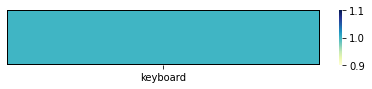

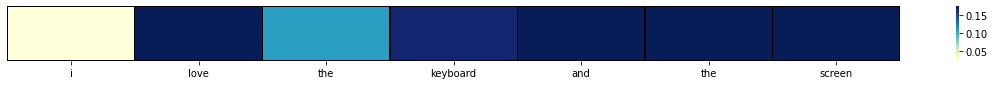

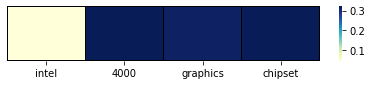

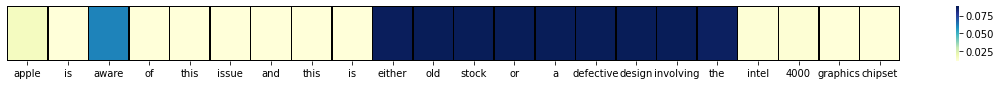

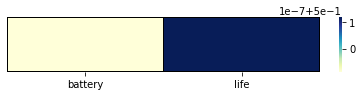

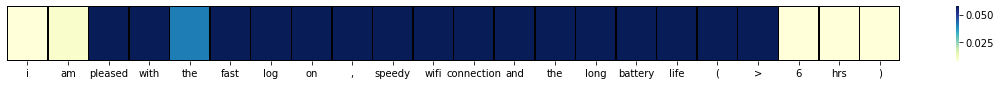

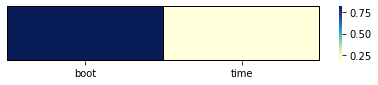

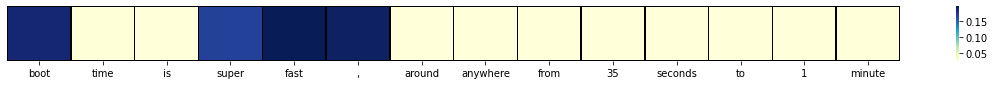

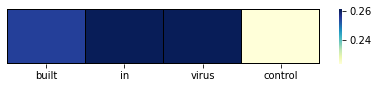

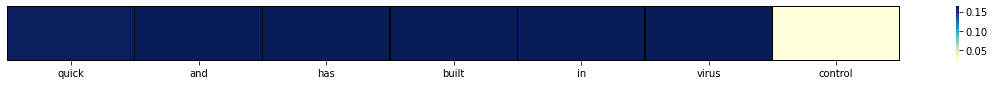

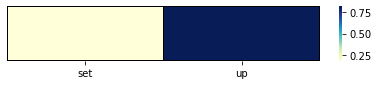

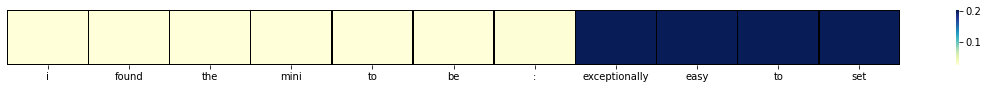

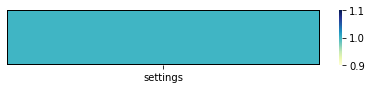

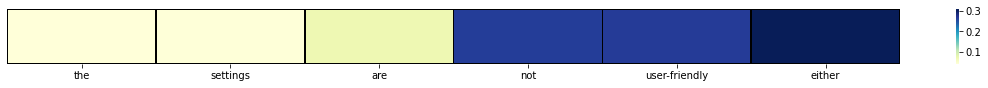

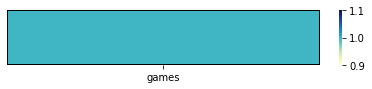

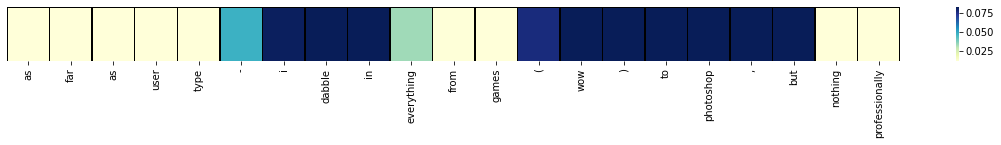

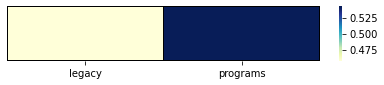

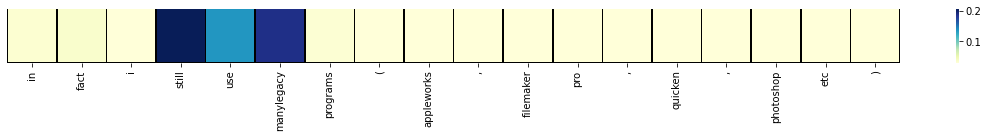

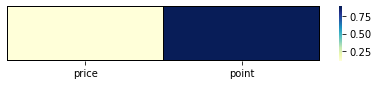

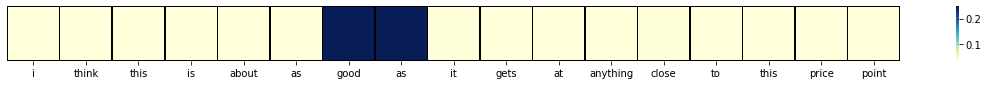



                     Context                       |   Target   |  Output  | True Label
------------------------------------------------------------------------------------------------------------------------
i used windows xp , windows vista , and windows 7 extensively | windows vista | neutral  | neutral 

having heard from friends and family about how reliable a mac product is , i never expected to have an application crash within the first month , but i did | application | positive | negative

it is a great size and amazing windows 8 included  |    size    | positive | positive

it is pretty snappy and starts up in about 30 seconds which is good enough for me | starts up  | positive | positive

you just can not beat the functionality of an apple device | functionality | positive | positive

              i love the form factor               | form factor | positive | positive

no cd rom in the new version there 's no way i 'm spending that kind of money on something has less feat

In [30]:
model = torch.load('/content/drive/MyDrive/DL/lian_model_with_attn_l2.pth')
illustrate_attention_weights(model=model, dataloader=l_test_loader, word2idx=lword2idx,path="attn")
display_prediction(model=model, dataloader=l_test_loader, word2idx=lword2idx)

In [33]:
model = torch.load('/content/drive/MyDrive/DL/lian_model_without_attn.pth')
display_prediction(model=model, dataloader=l_test_loader, word2idx=lword2idx)



                     Context                       |   Target   |  Output  | True Label
------------------------------------------------------------------------------------------------------------------------
it just works out of the box and you have a lot of cool software included with the os |   works    | positive | positive

  fan only comes on when you are playing a game    | playing a game | neutral  | neutral 

i ca n't believe how quiet the hard drive is and how quick this thing boots up | hard drive | positive | positive

i had to get apple customer support to correct the problem | apple customer support | neutral  | neutral 

working with mac is so much easier , so many cool features |  working   | positive | positive

a veryimportant feature is firewire 800 which in my experience works better then usb3 ( in pc enabled with usb3 ) i was not originally sold on the mac os i felt it was inferior in many ways to windows 7 |   mac os   | positive | negative

the battery life is 

In [34]:
model = torch.load('/content/drive/MyDrive/DL/lian_model_without_attn_l2.pth')
display_prediction(model=model, dataloader=l_test_loader, word2idx=lword2idx)



                     Context                       |   Target   |  Output  | True Label
------------------------------------------------------------------------------------------------------------------------
i ca n't believe how quiet the hard drive is and how quick this thing boots up |  boots up  | positive | positive

boot-up slowed significantly after all windows updates were installed |  boot-up   | negative | negative

i like the design and ease of use with the keyboard , plenty of ports |  keyboard  | positive | positive

if you ask me , for this price it should be included |   price    | positive | negative

the power plug has to be connected to the power adaptor to charge the battery but wo n't stay connected |  battery   | negative | neutral 

this newer netbook has no hard drive or network lights | network lights | negative | neutral 

       exactly as posted plus a great value        |   value    | positive | positive

put a ssd and use a 21 '' led screen , this set up 